In [38]:
import xarray as xr
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import KNN
from eval.metrics import *
from eval.plot import *
import data.valid_crd as valid_crd
import glob
import os
import yaml
import data.helper as helper

In [39]:
## load inputs
test_period = [2001, 2014]
exps  = ['0bc32e5c', '7f6b6147']
testep = [50, 50]
ref_eval = '7f6b6147' #which reference data to be used
compare_methods = ['LOCA', 'QM']

In [40]:
def load_model_run(run_id, est_period, epoch=None, base_dir='/pscratch/sd/k/kas7897/diffDownscale/jobs'):
    run_path = helper.load_run_path(run_id, base_dir)

    flat_dir = os.path.join(run_path, f"{test_period[0]}_{test_period[1]}")

    # Check which structure exists
    data_path = flat_dir
    config_path = os.path.join(run_path, 'train_config.yaml')

    x = torch.load(os.path.join(data_path, 'x.pt'), map_location='cpu').squeeze(-1).numpy()
    x[x<0.254] = 0 
    y = torch.load(os.path.join(data_path, 'y.pt'), map_location='cpu').squeeze(-1).numpy()
    y[y<0.254] = 0
    time = torch.load(os.path.join(data_path, 'time.pt'), map_location='cpu')

    xt = None
    if epoch is not None:
        xt_path = os.path.join(data_path, f'ep{epoch}', 'xt.pt')
        if os.path.exists(xt_path):
            xt = torch.load(xt_path, map_location='cpu')
        xt[xt<0.254] = 0

    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    return {
        'run_path': run_path,
        'x': x,
        'y': y,
        'time': time,
        'xt': xt,
        'config': config
    }

models = []
for i in range(len(exps)):
    model = load_model_run(exps[i], test_period, epoch=testep[i])
    models.append(model)

In [41]:
method_names = []

for i, model in enumerate(models):
    config = model['config']
    
    ref = config['ref']
    degree = config['degree']
    emph_quantile = config['emph_quantile']
    time_scale = config['time_scale']
    ep = testep[i]

    method_name = f"delCLIMAD-BA({ref}_degree{degree}_quantile{emph_quantile}_ep{ep}_{time_scale})"
    method_names.append(method_name)


method_names = method_names + compare_methods

cmip6_dir = models[0]['config']['cmip_dir']
clim = models[0]['config']['clim']
ref = models[0]['config']['ref']
ref_var = models[0]['config']['ref_var']
shapefile_path = None if not  models[0]['config']['spatial_test']  else models[0]['config']['shapefile_filter_path']
train_period = [models[0]['config']['train_start'], models[0]['config']['train_end']]

try:
    spatial_extent = models[0]['config']['spatial_extent_test']
except:
    spatial_extent = models[0]['config']['spatial_extent_val']


ds_sample = xr.open_dataset(f"{cmip6_dir}/{clim}/historical/precipitation/clipped_US.nc")
valid_coords = valid_crd.valid_lat_lon(ds_sample, var_name='pr', shapefile_path=shapefile_path, attrList=spatial_extent)

In [42]:

## Loading competitors
if 'LOCA' in method_names:
    loca = xr.open_dataset(f'{cmip6_dir}/{clim}/historical/precipitation/loca/coarse_USclip.nc')
    loca = loca['pr'].sel(lat=xr.DataArray(valid_coords[:, 0], dims='points'),
                                        lon=xr.DataArray(valid_coords[:, 1], dims='points'),
                                        method='nearest')
    loca = loca.sel(time =slice(f'{test_period[0]}', f'{test_period[1]}')).values

    #unit conversion
    loca = loca*86400




if 'QM' in method_names:
    QM_bench = f'benchmark/QuantileMapping/conus/{clim}-{ref}/{train_period}_historical_{test_period}.pt'
    QM_debiased = torch.load(QM_bench, weights_only=False).squeeze(-1)
    QM_debiased = QM_debiased*86400

In [43]:
## this block filters 'y' based on 'x' calender
for model in models:
    time = model['time']
    
    x_time_np = np.array([pd.Timestamp(str(t)) for t in time])
    x_time_np = np.array([pd.Timestamp(t).replace(hour=0, minute=0, second=0) for t in x_time_np], dtype='datetime64[D]')
    # Generate a daily time array following the standard Gregorian calendar
    y_time = pd.date_range(start=f"{test_period[0]}-01-01", end=f"{test_period[1]}-12-31", freq="D")

    # Convert to NumPy array for indexing and comparison
    y_time_np = y_time.to_numpy()

    # Find indices where observed time matches model time
    matched_indices = np.where(np.isin(y_time_np, x_time_np))[0]

    model['y'] = model['y'][matched_indices,:]
    model['x_time_np'] = x_time_np

    # loca = loca[matched_indices, :]


ref_eval_data = models[exps.index(ref_eval)]['y']


### 10 Individual Locations Analysis

In [44]:
cities = {
    "Pittsburgh": [40.437, -80.079],
    "Phoenix": [33.431, -112.008],
    "ARM site": [36.608, -97.488],
    "Sioux City": [42.387, -96.369],
    "Boulder": [39.998, -105.268],
    "Birmingham": [33.568, -86.751],
    "Ft Logan": [46.543, -110.902],
    "Seattle": [47.545, -122.243],
    "Yosemite": [37.749, -119.590],
    "Orlando": [28.450, -81.741],
}

# Convert to array
city_names = list(cities.keys())
city_coords = np.array(list(cities.values()))  # shape (10, 2)

# Assuming valid_coords is already loaded as a numpy array (lat, lon)
# Compute distances between each city and all valid_coords
def find_nearest_indices(city_coords, valid_coords):
    nearest_indices = []
    nearest_coords = []

    for coord in city_coords:
        # Broadcasting subtraction
        dists = np.linalg.norm(valid_coords - coord, axis=1)
        idx = np.argmin(dists)
        nearest_indices.append(idx)
        nearest_coords.append(valid_coords[idx])

    return nearest_indices, np.array(nearest_coords)

# Call the function
nearest_indices, nearest_coords = find_nearest_indices(city_coords, valid_coords)


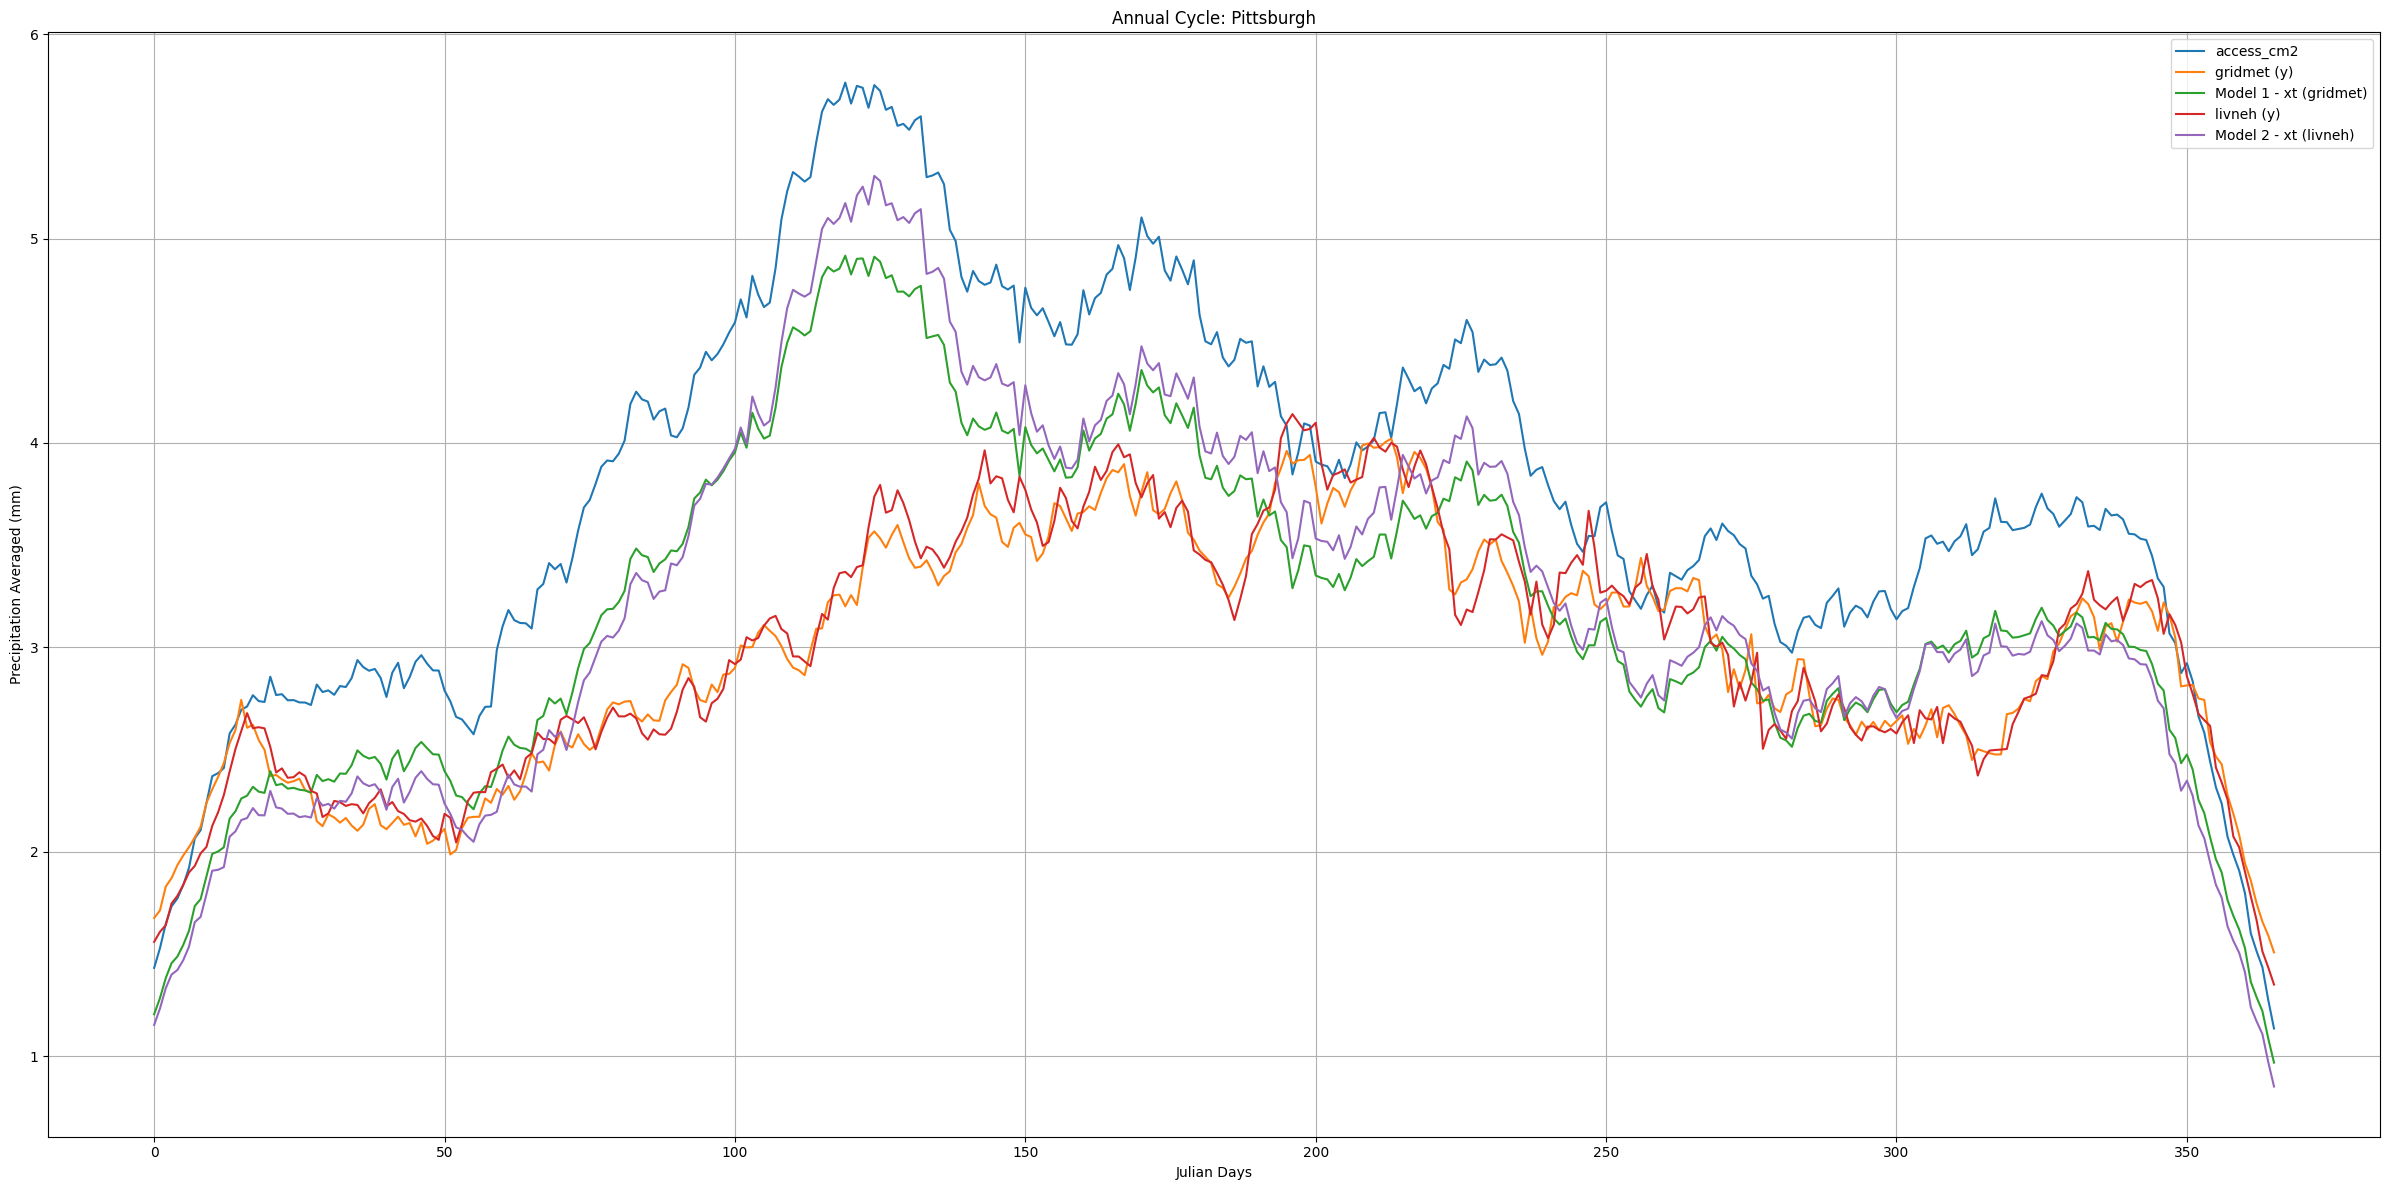

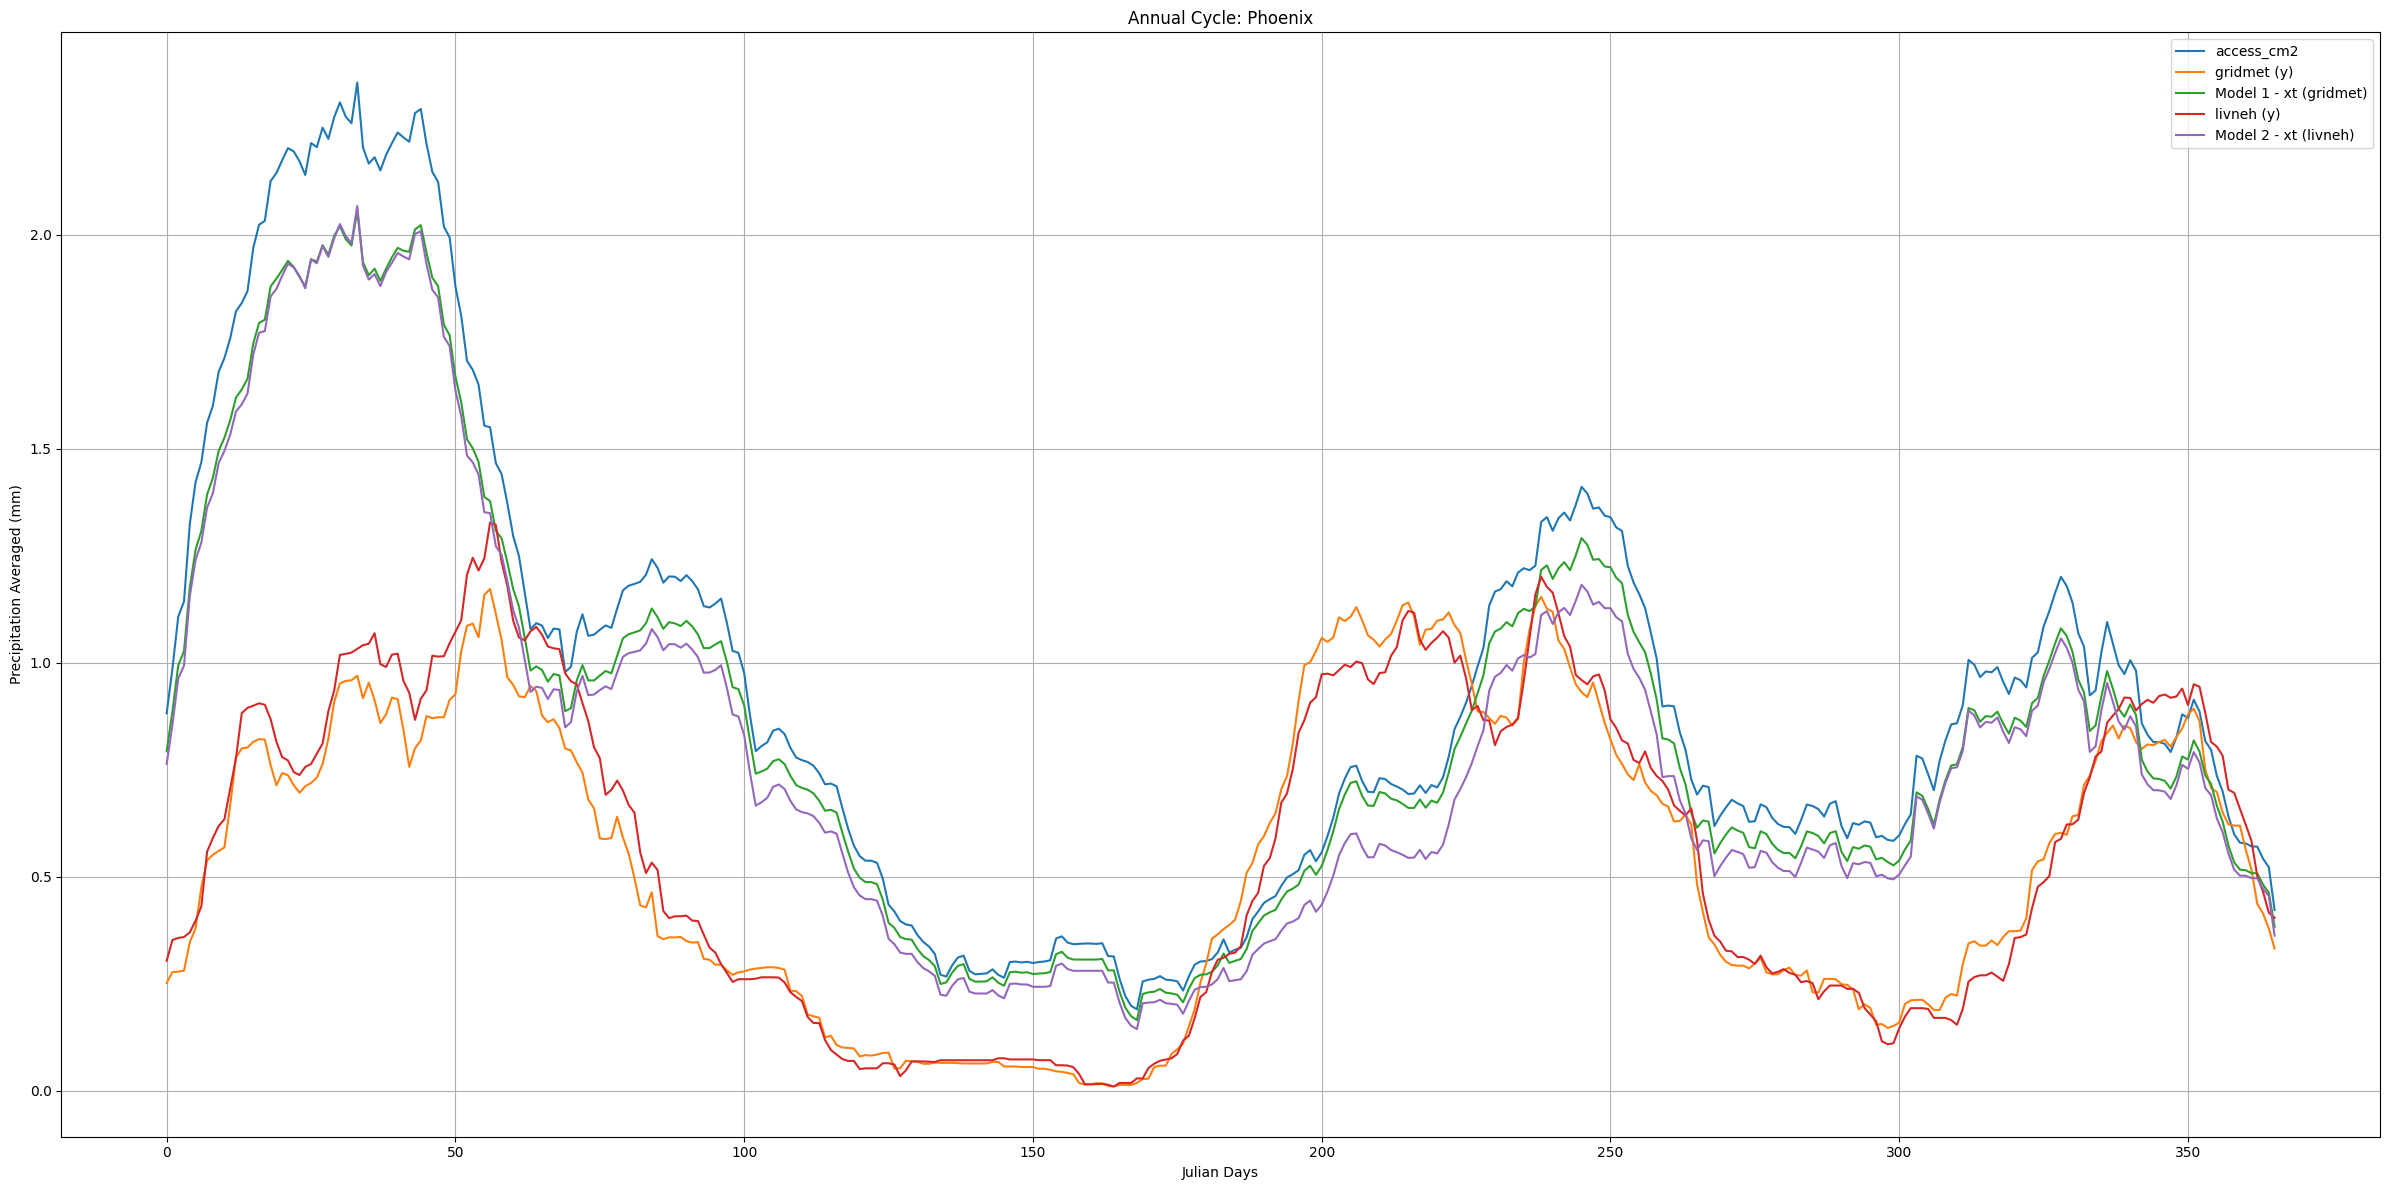

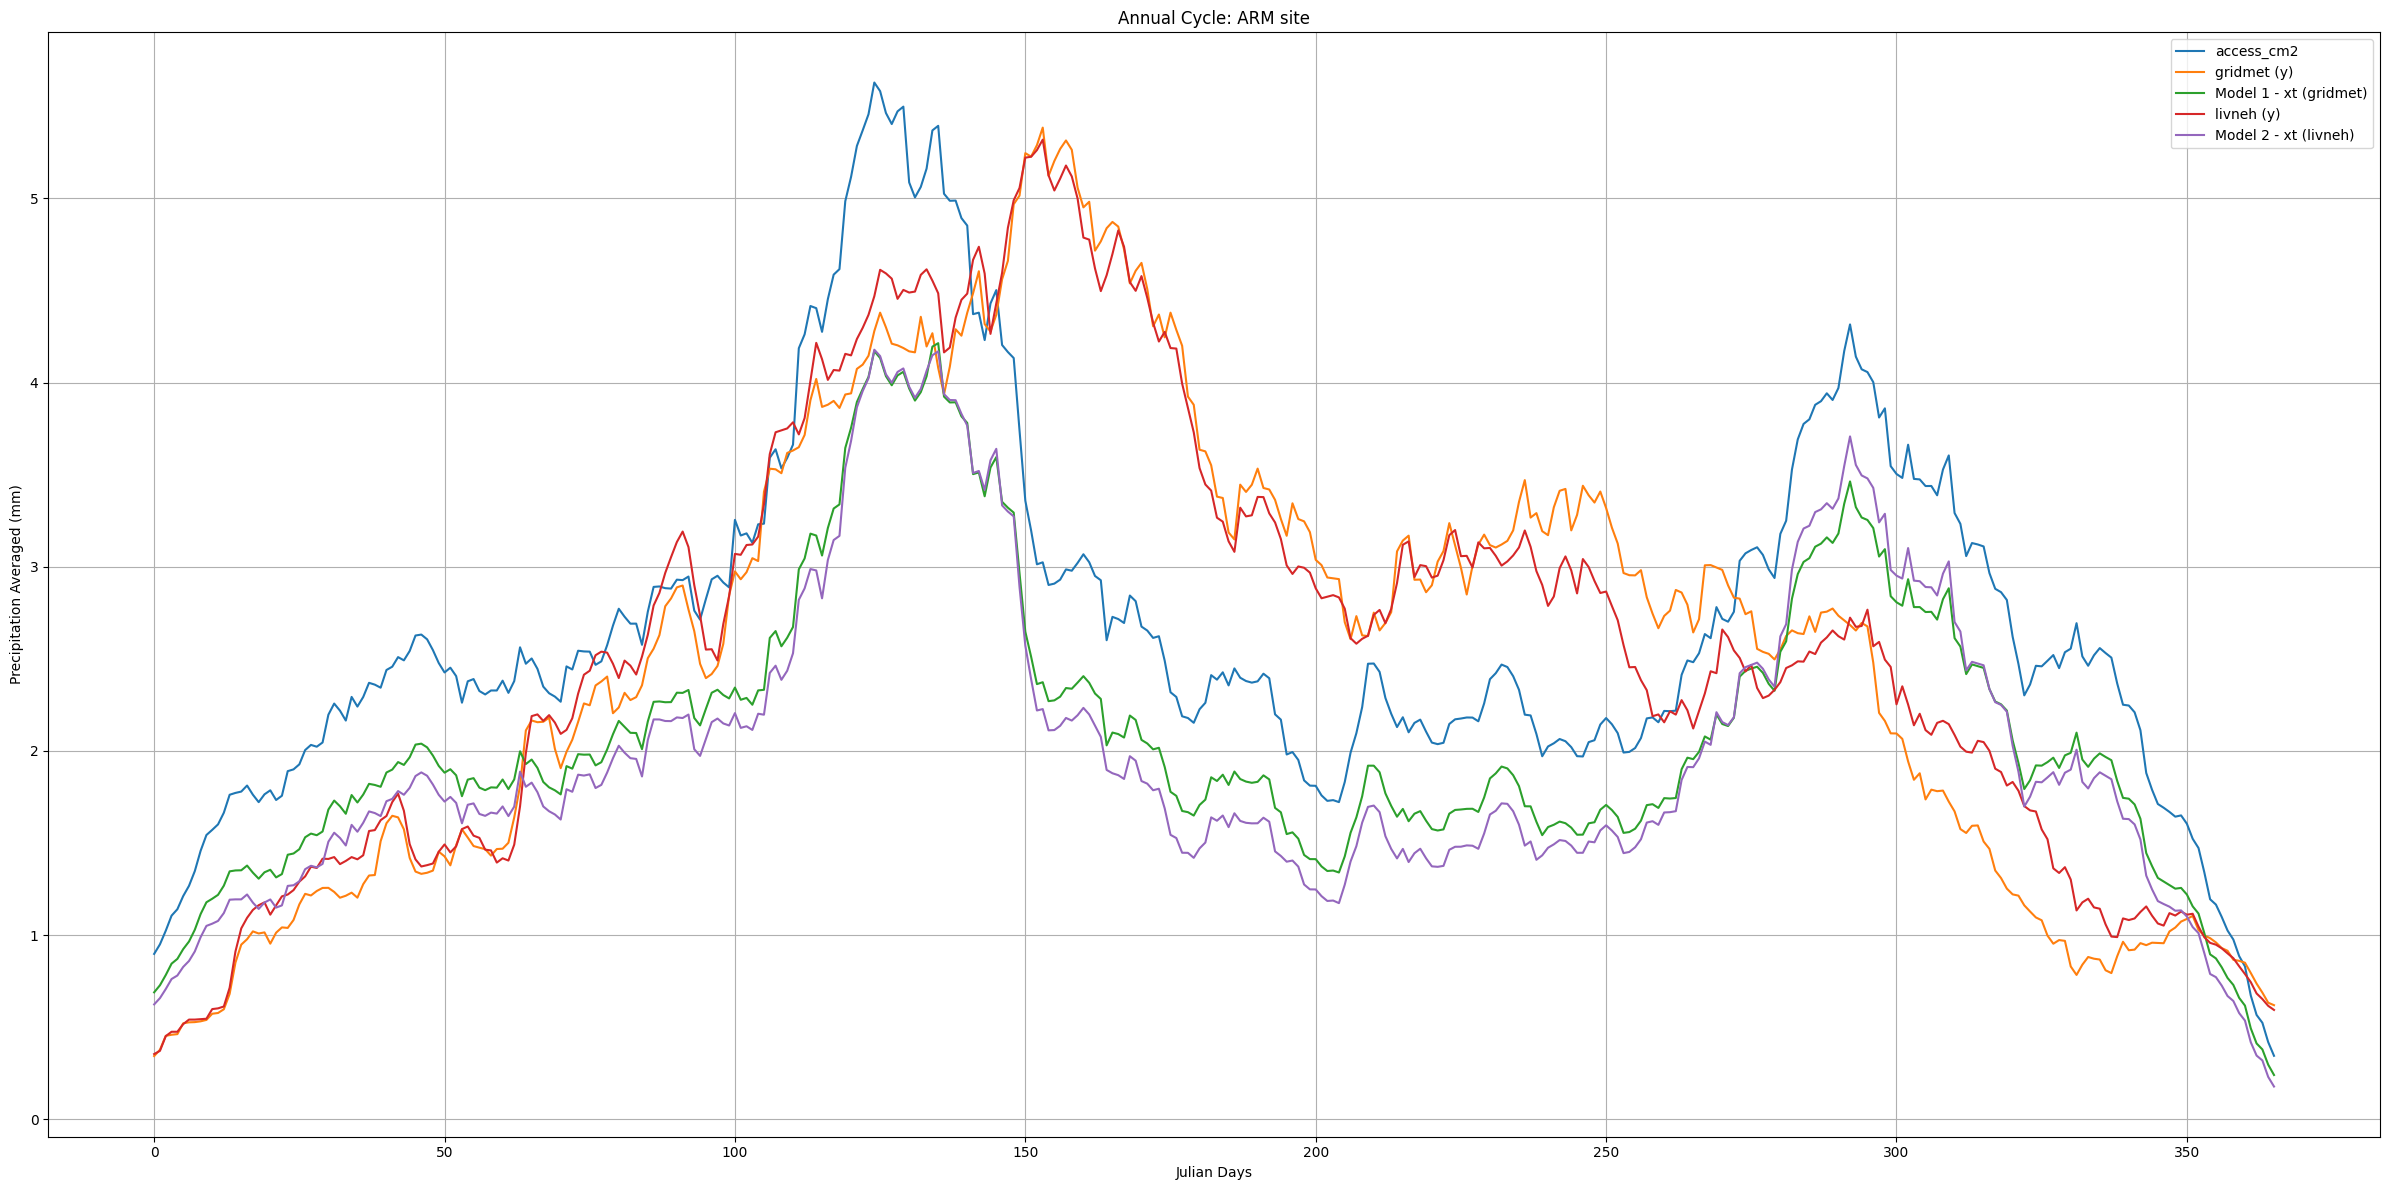

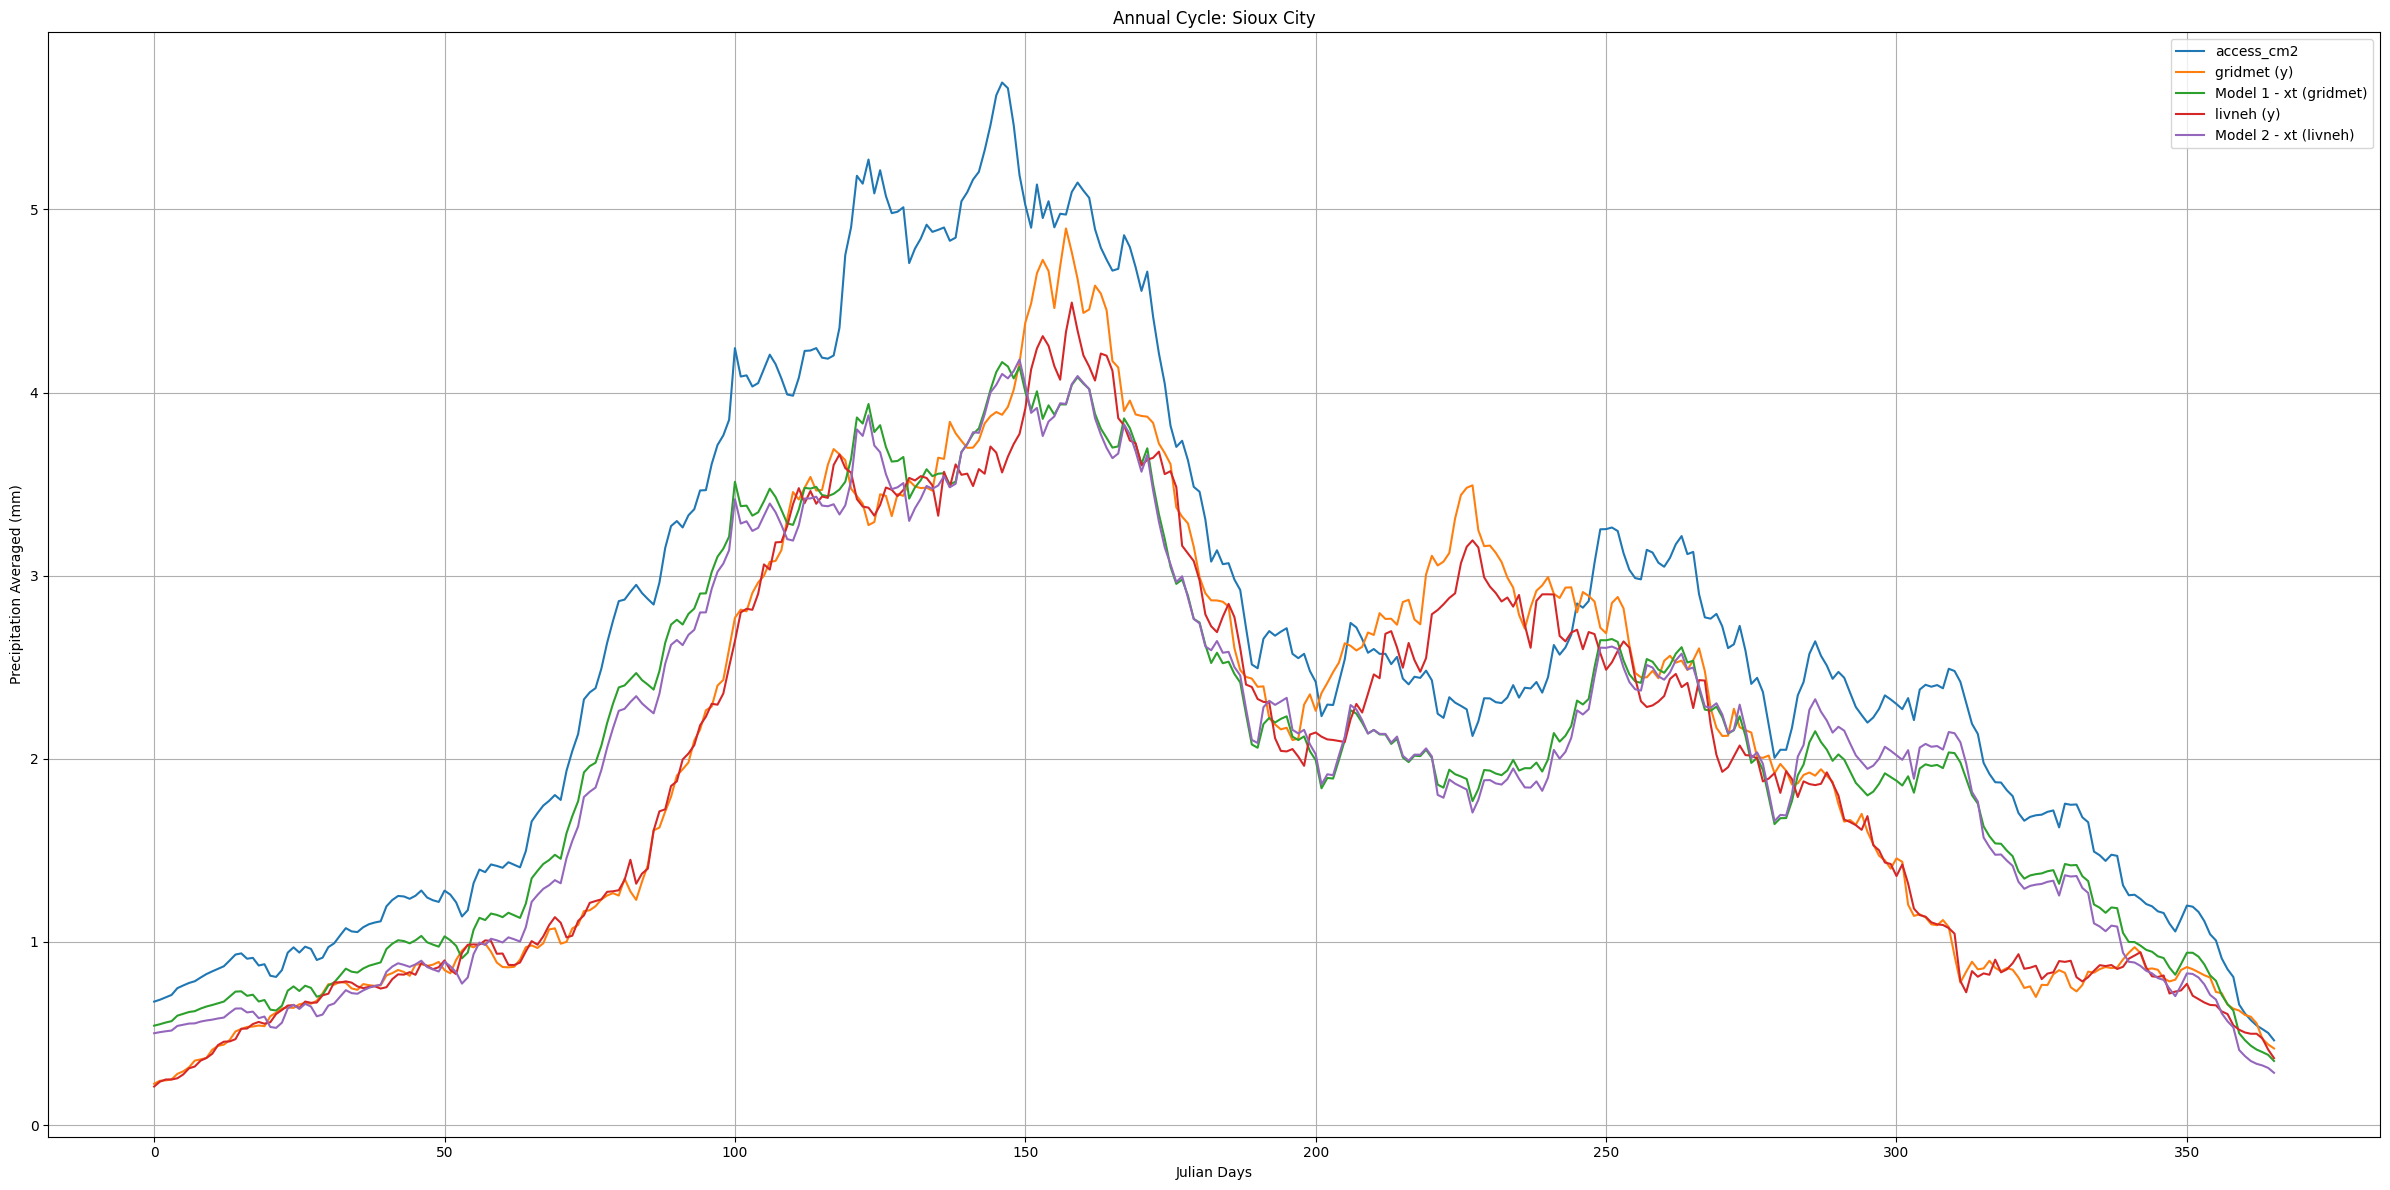

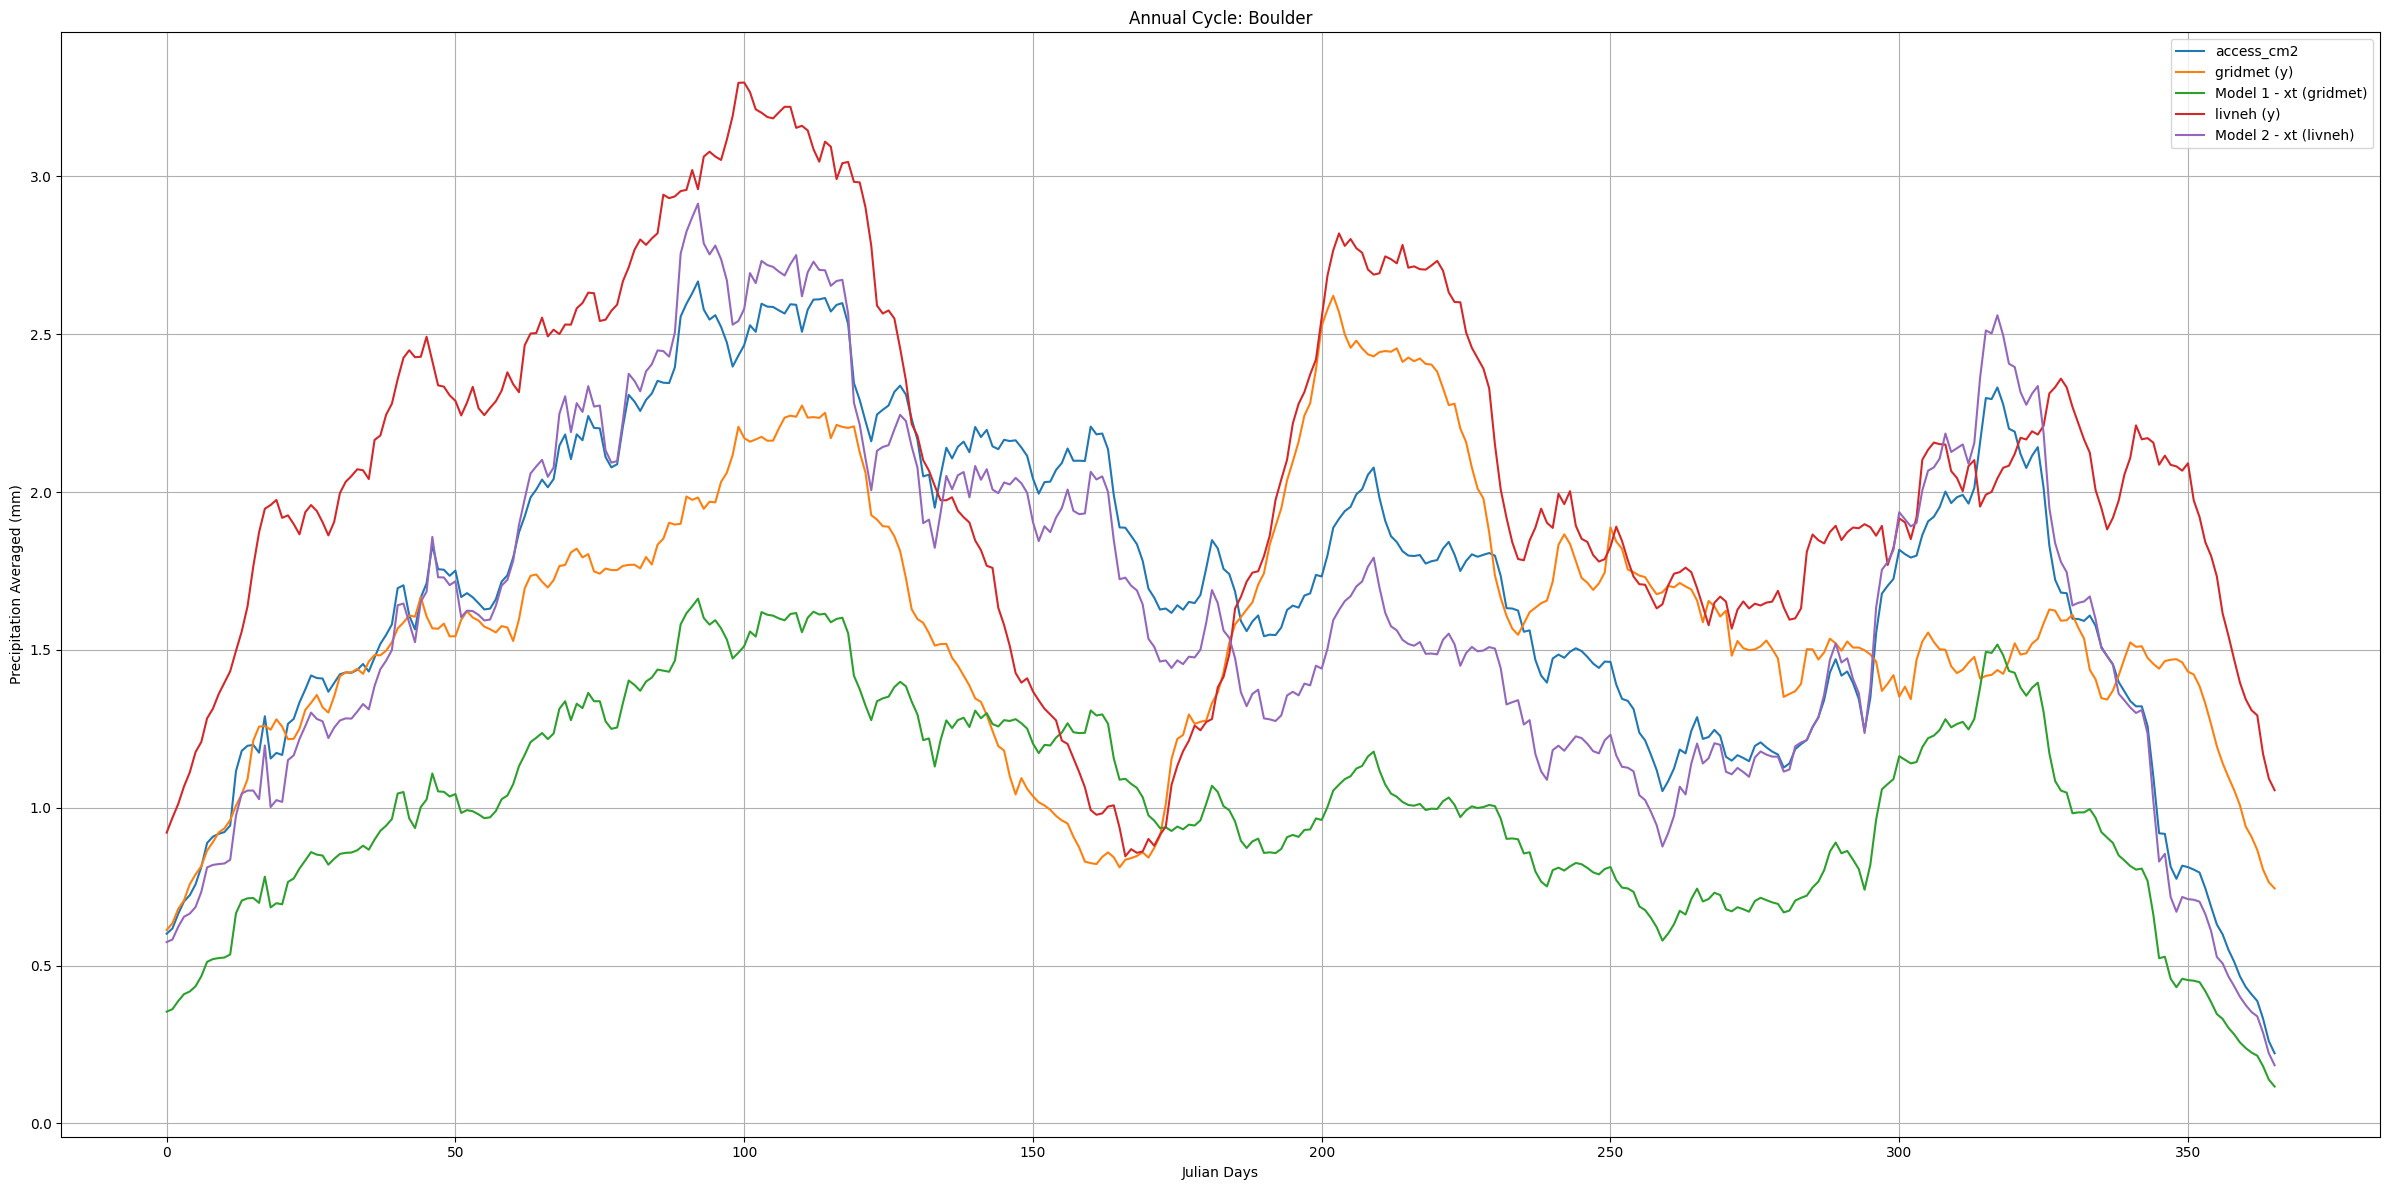

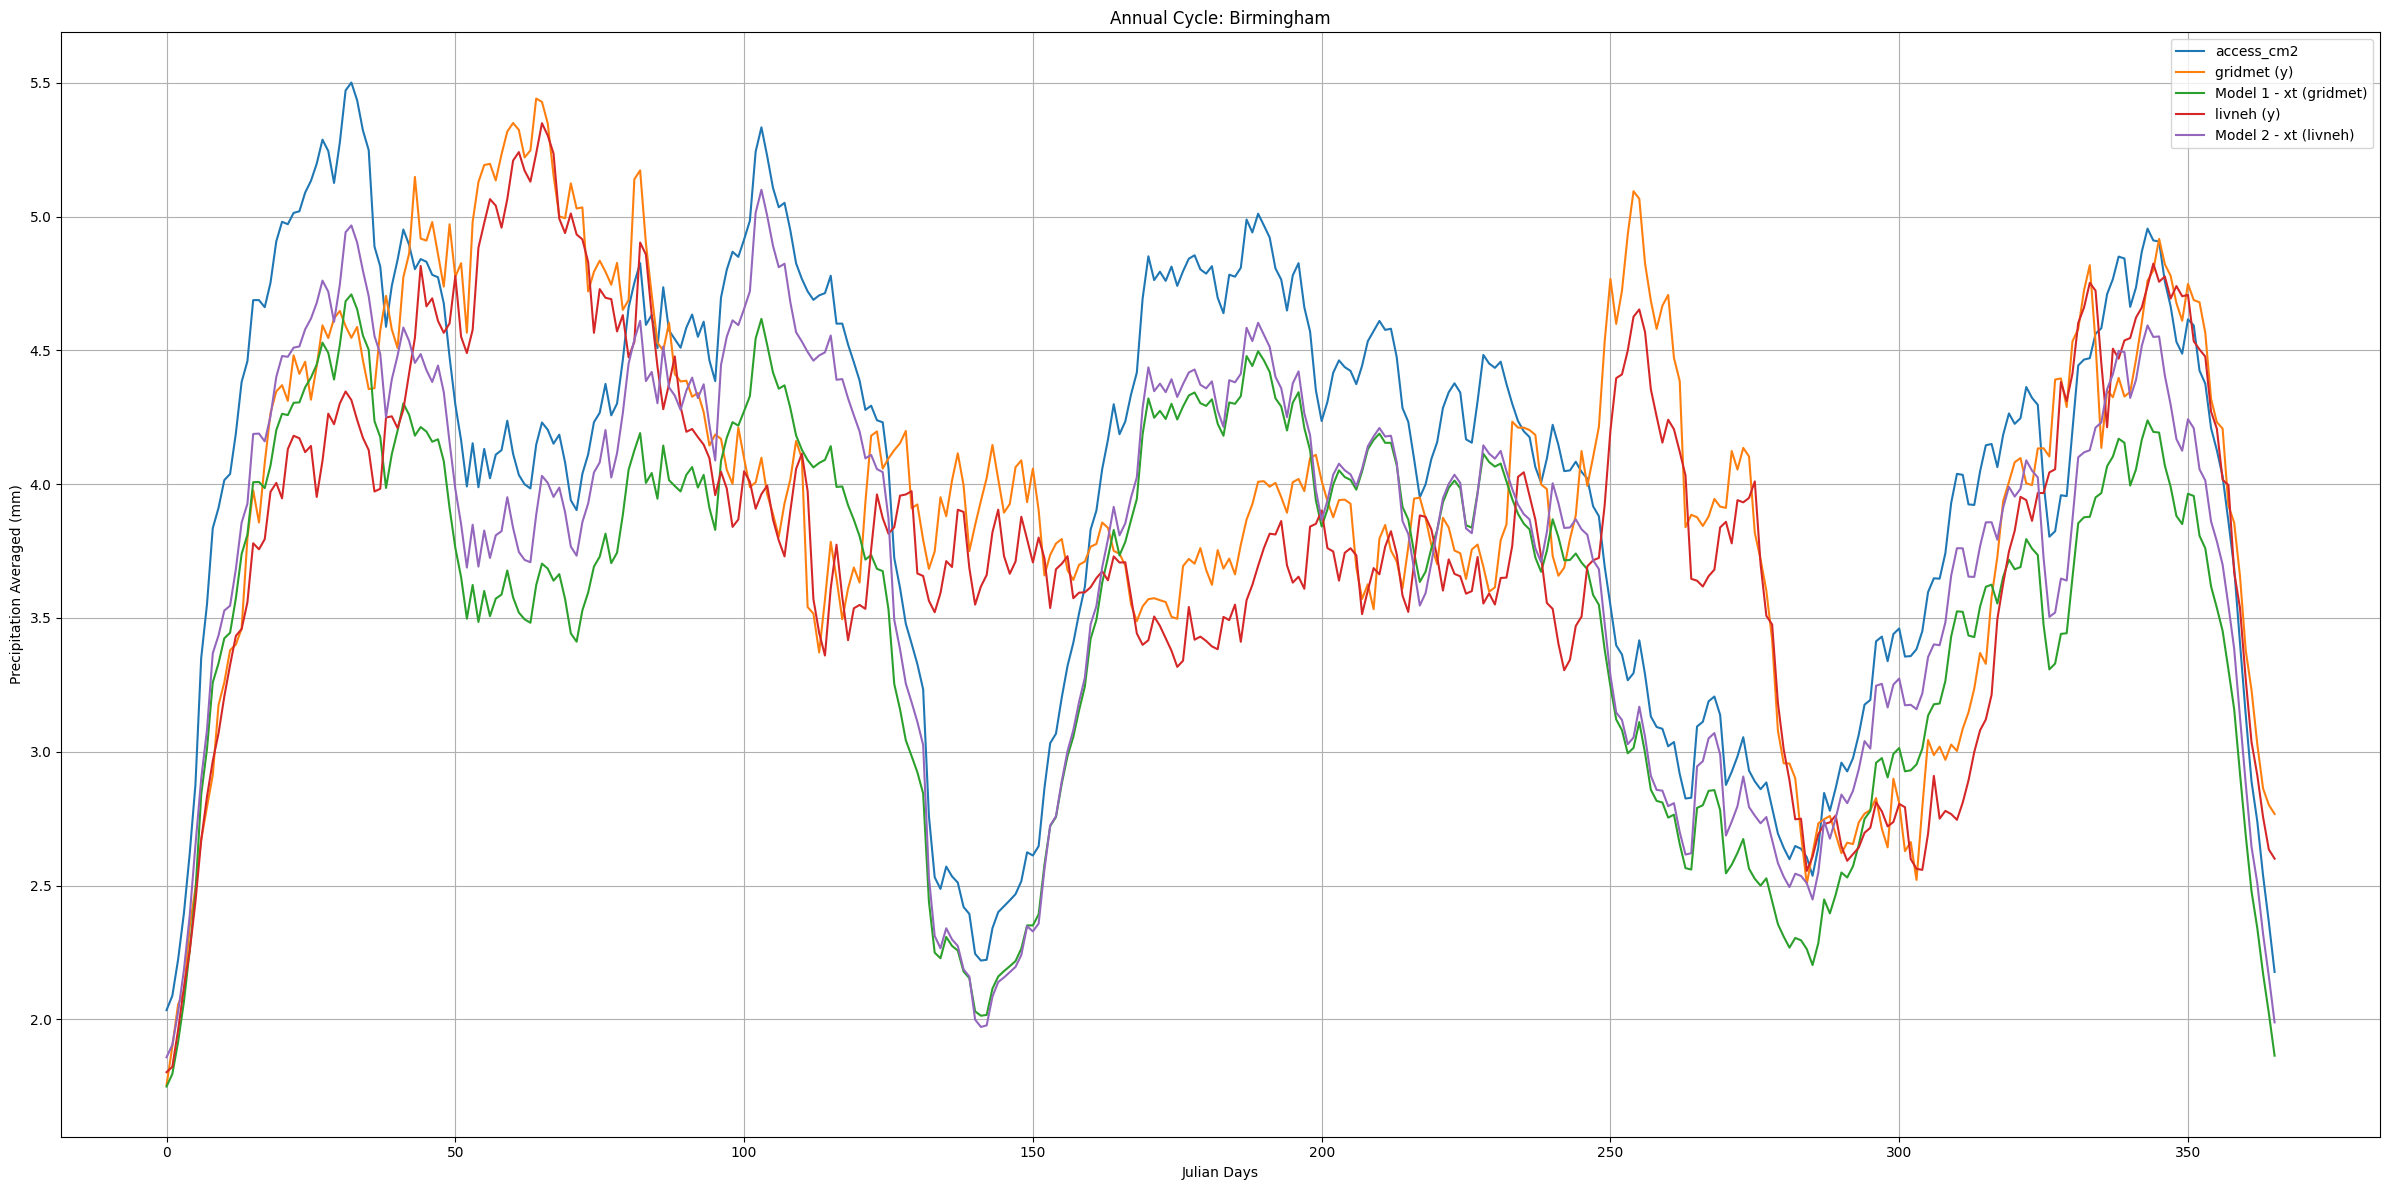

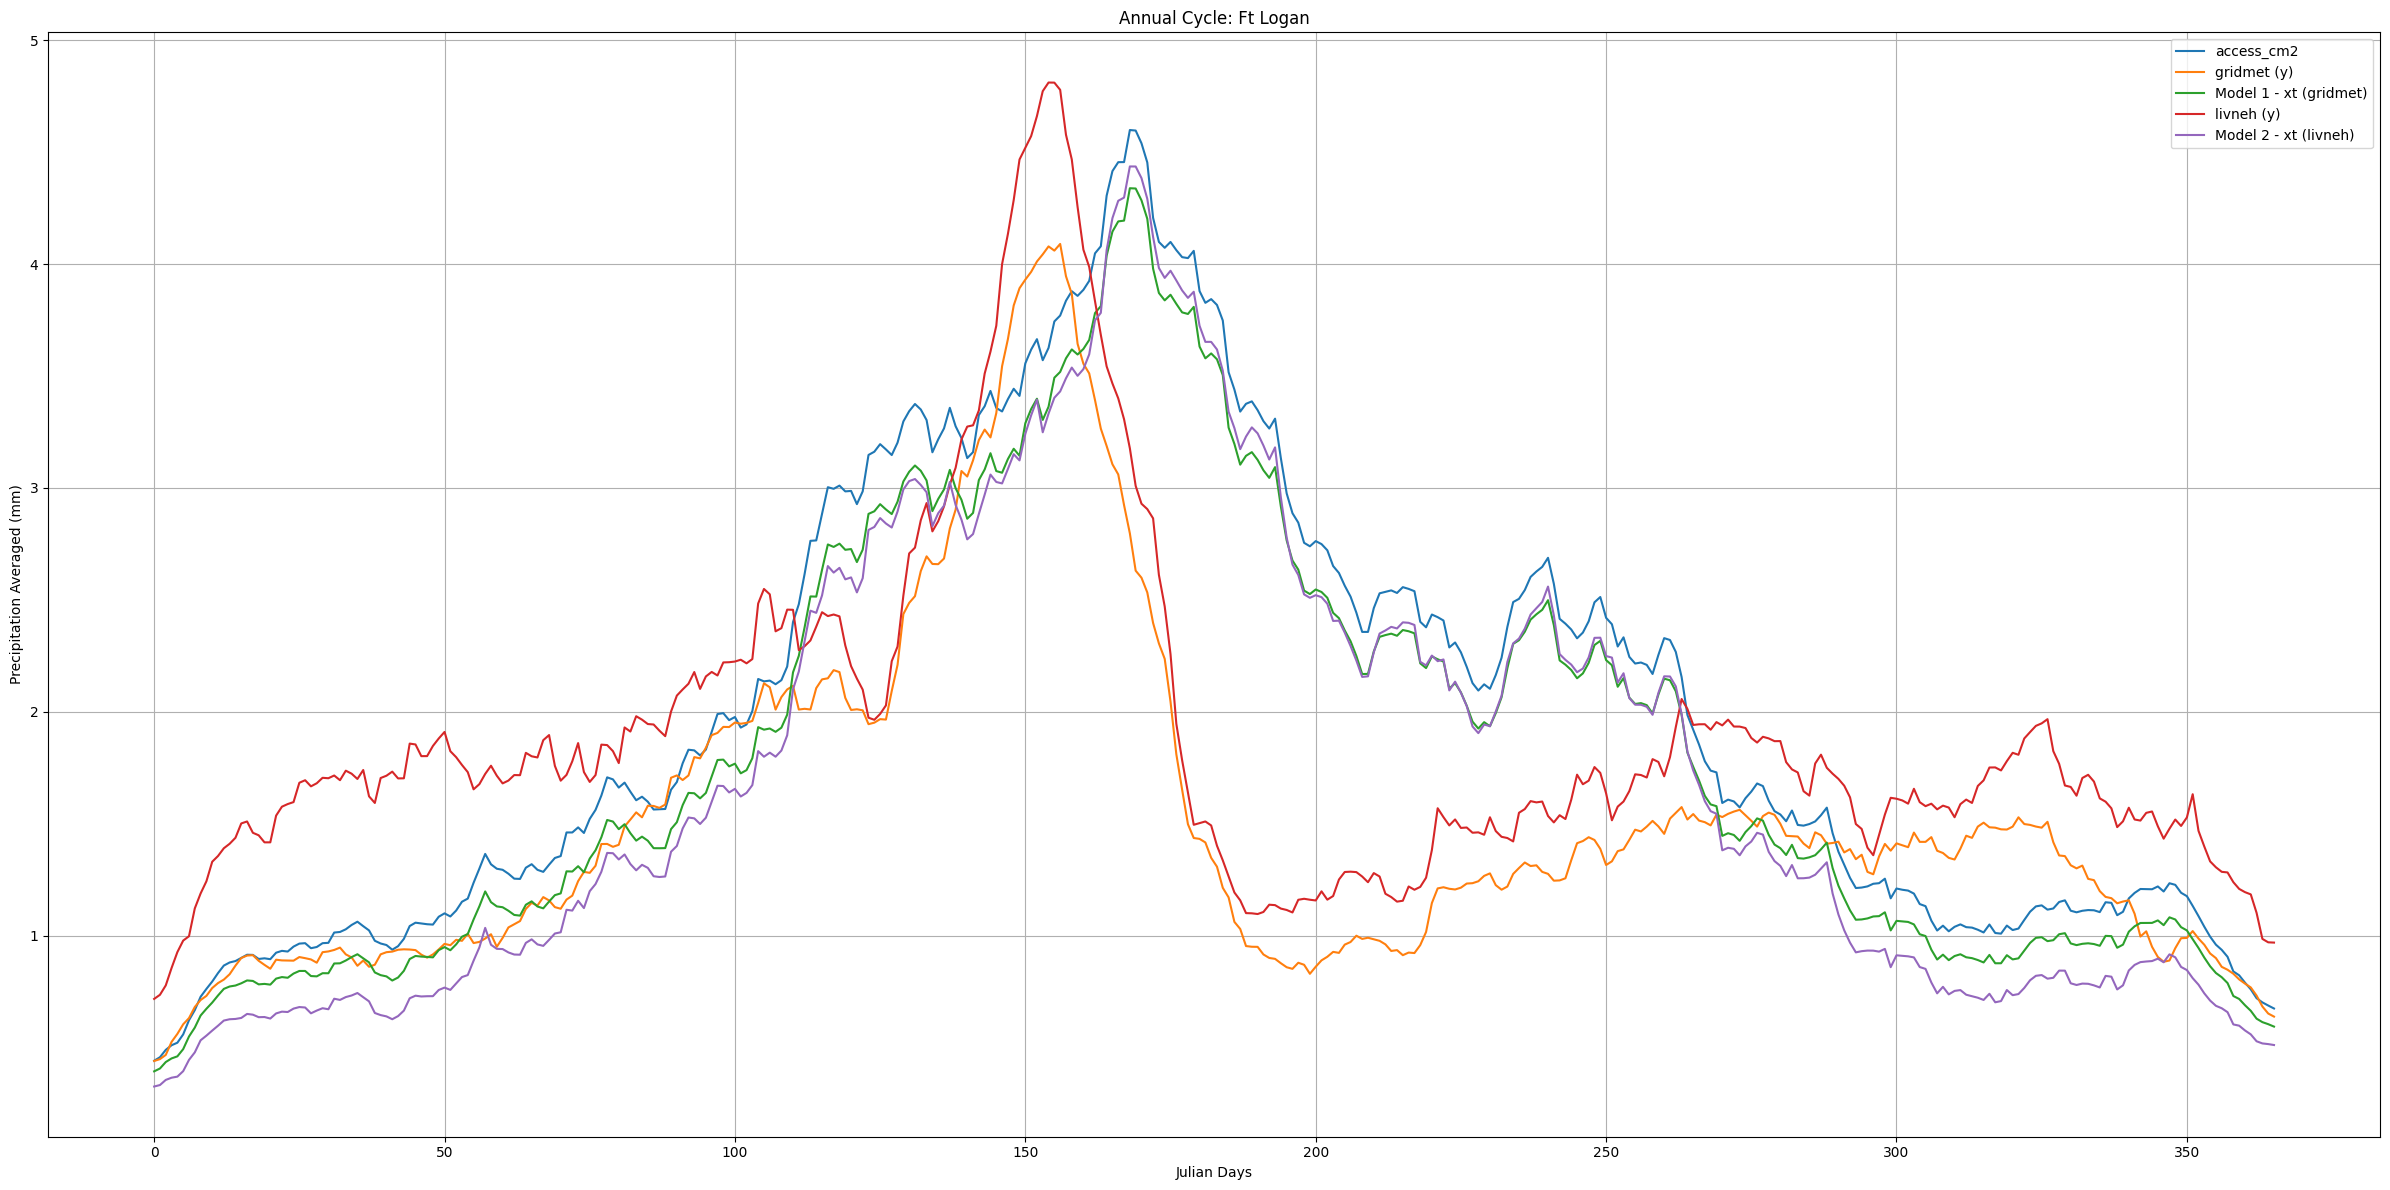

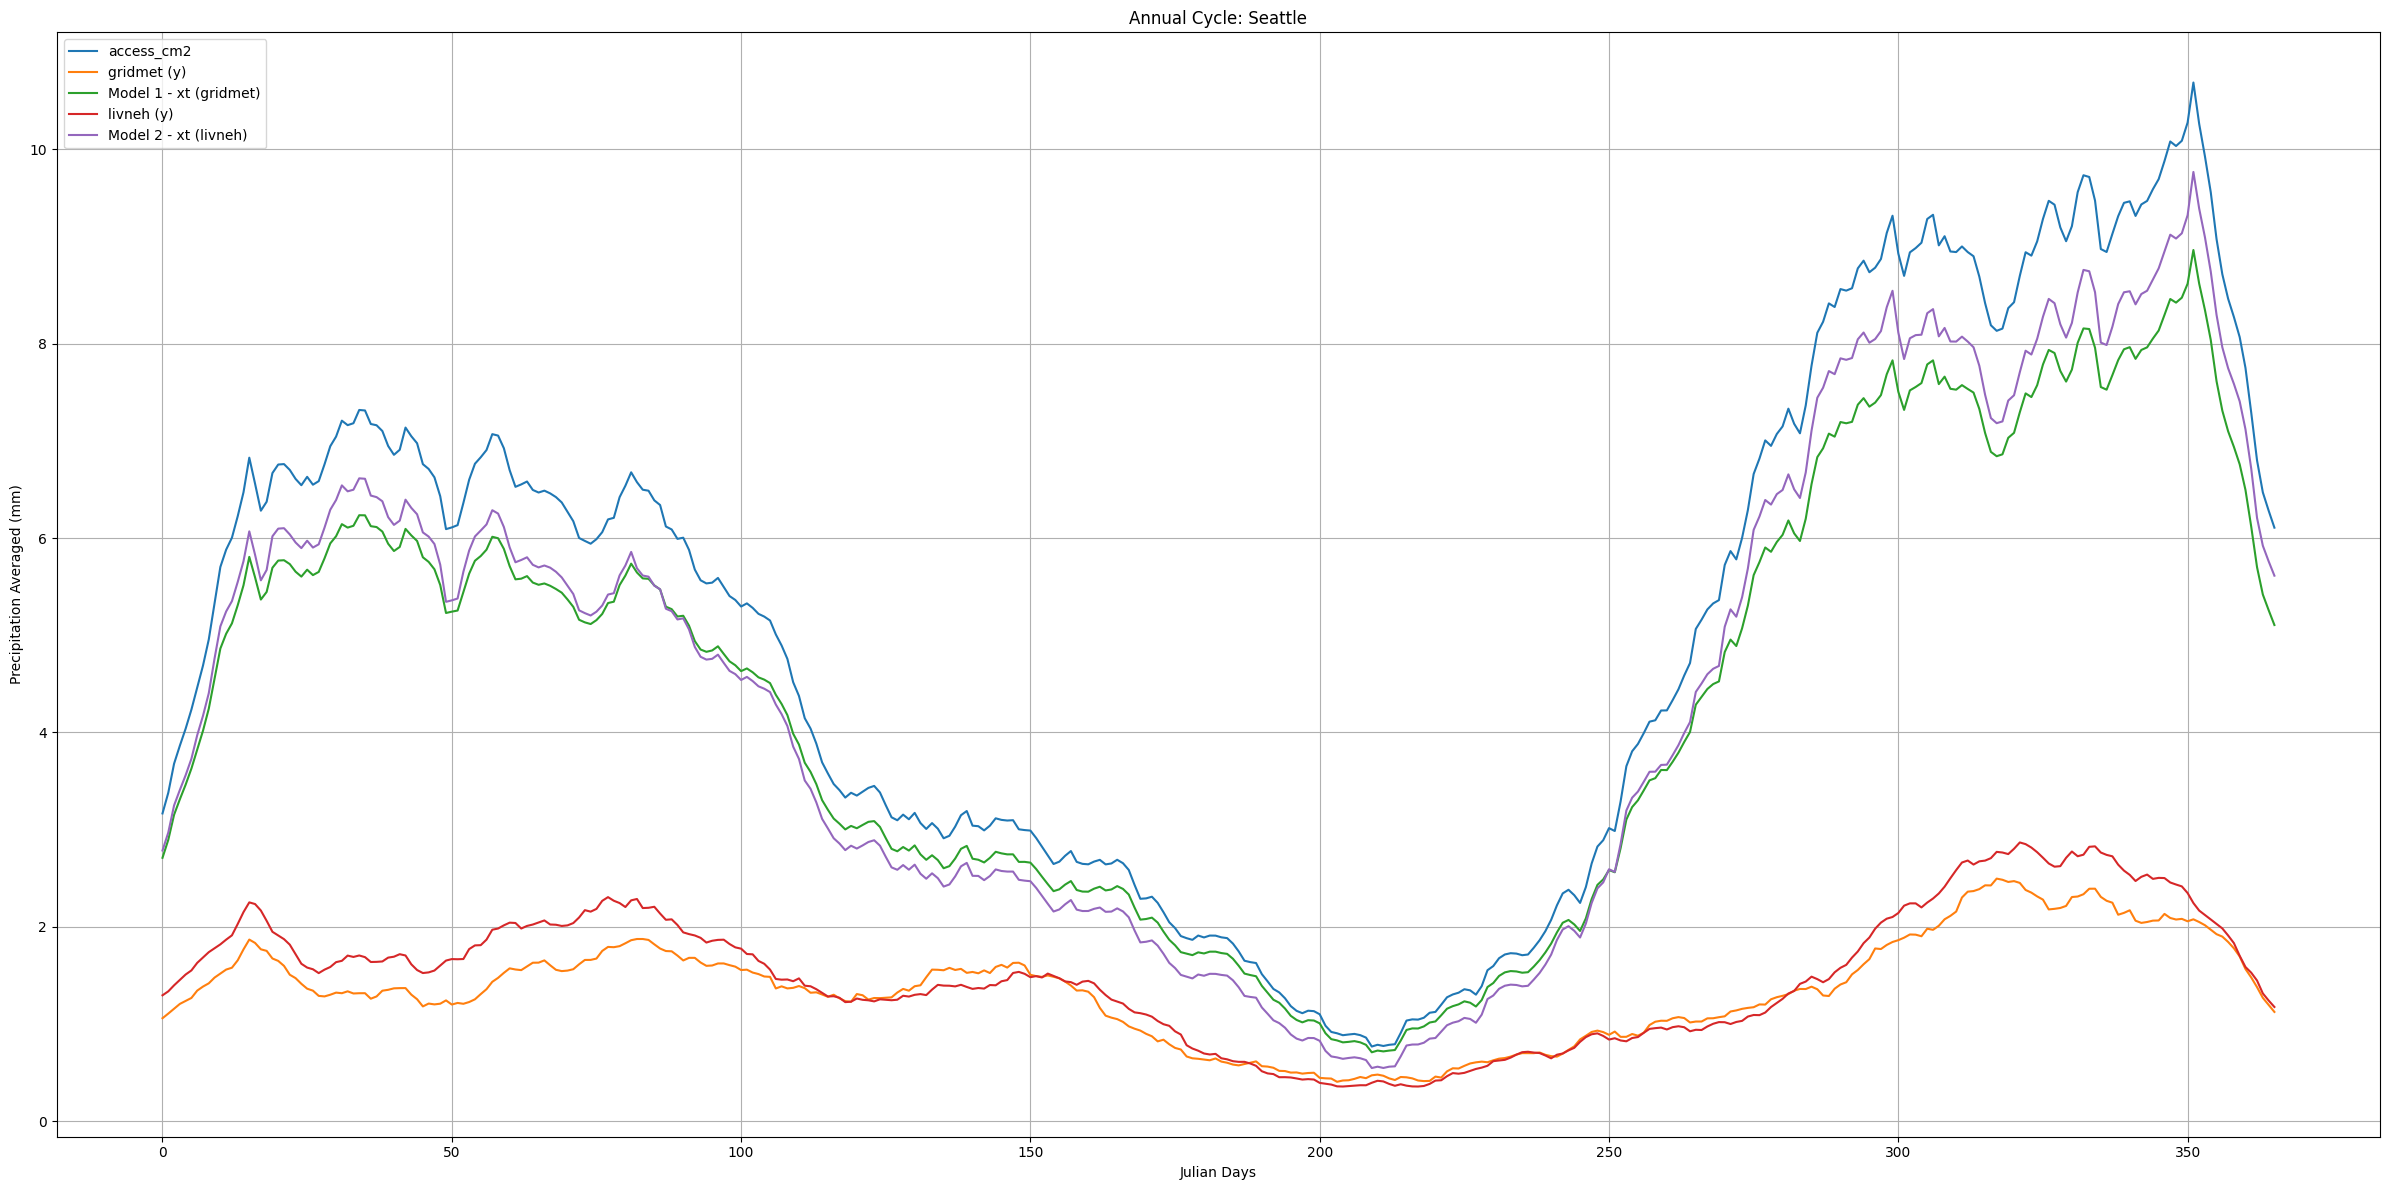

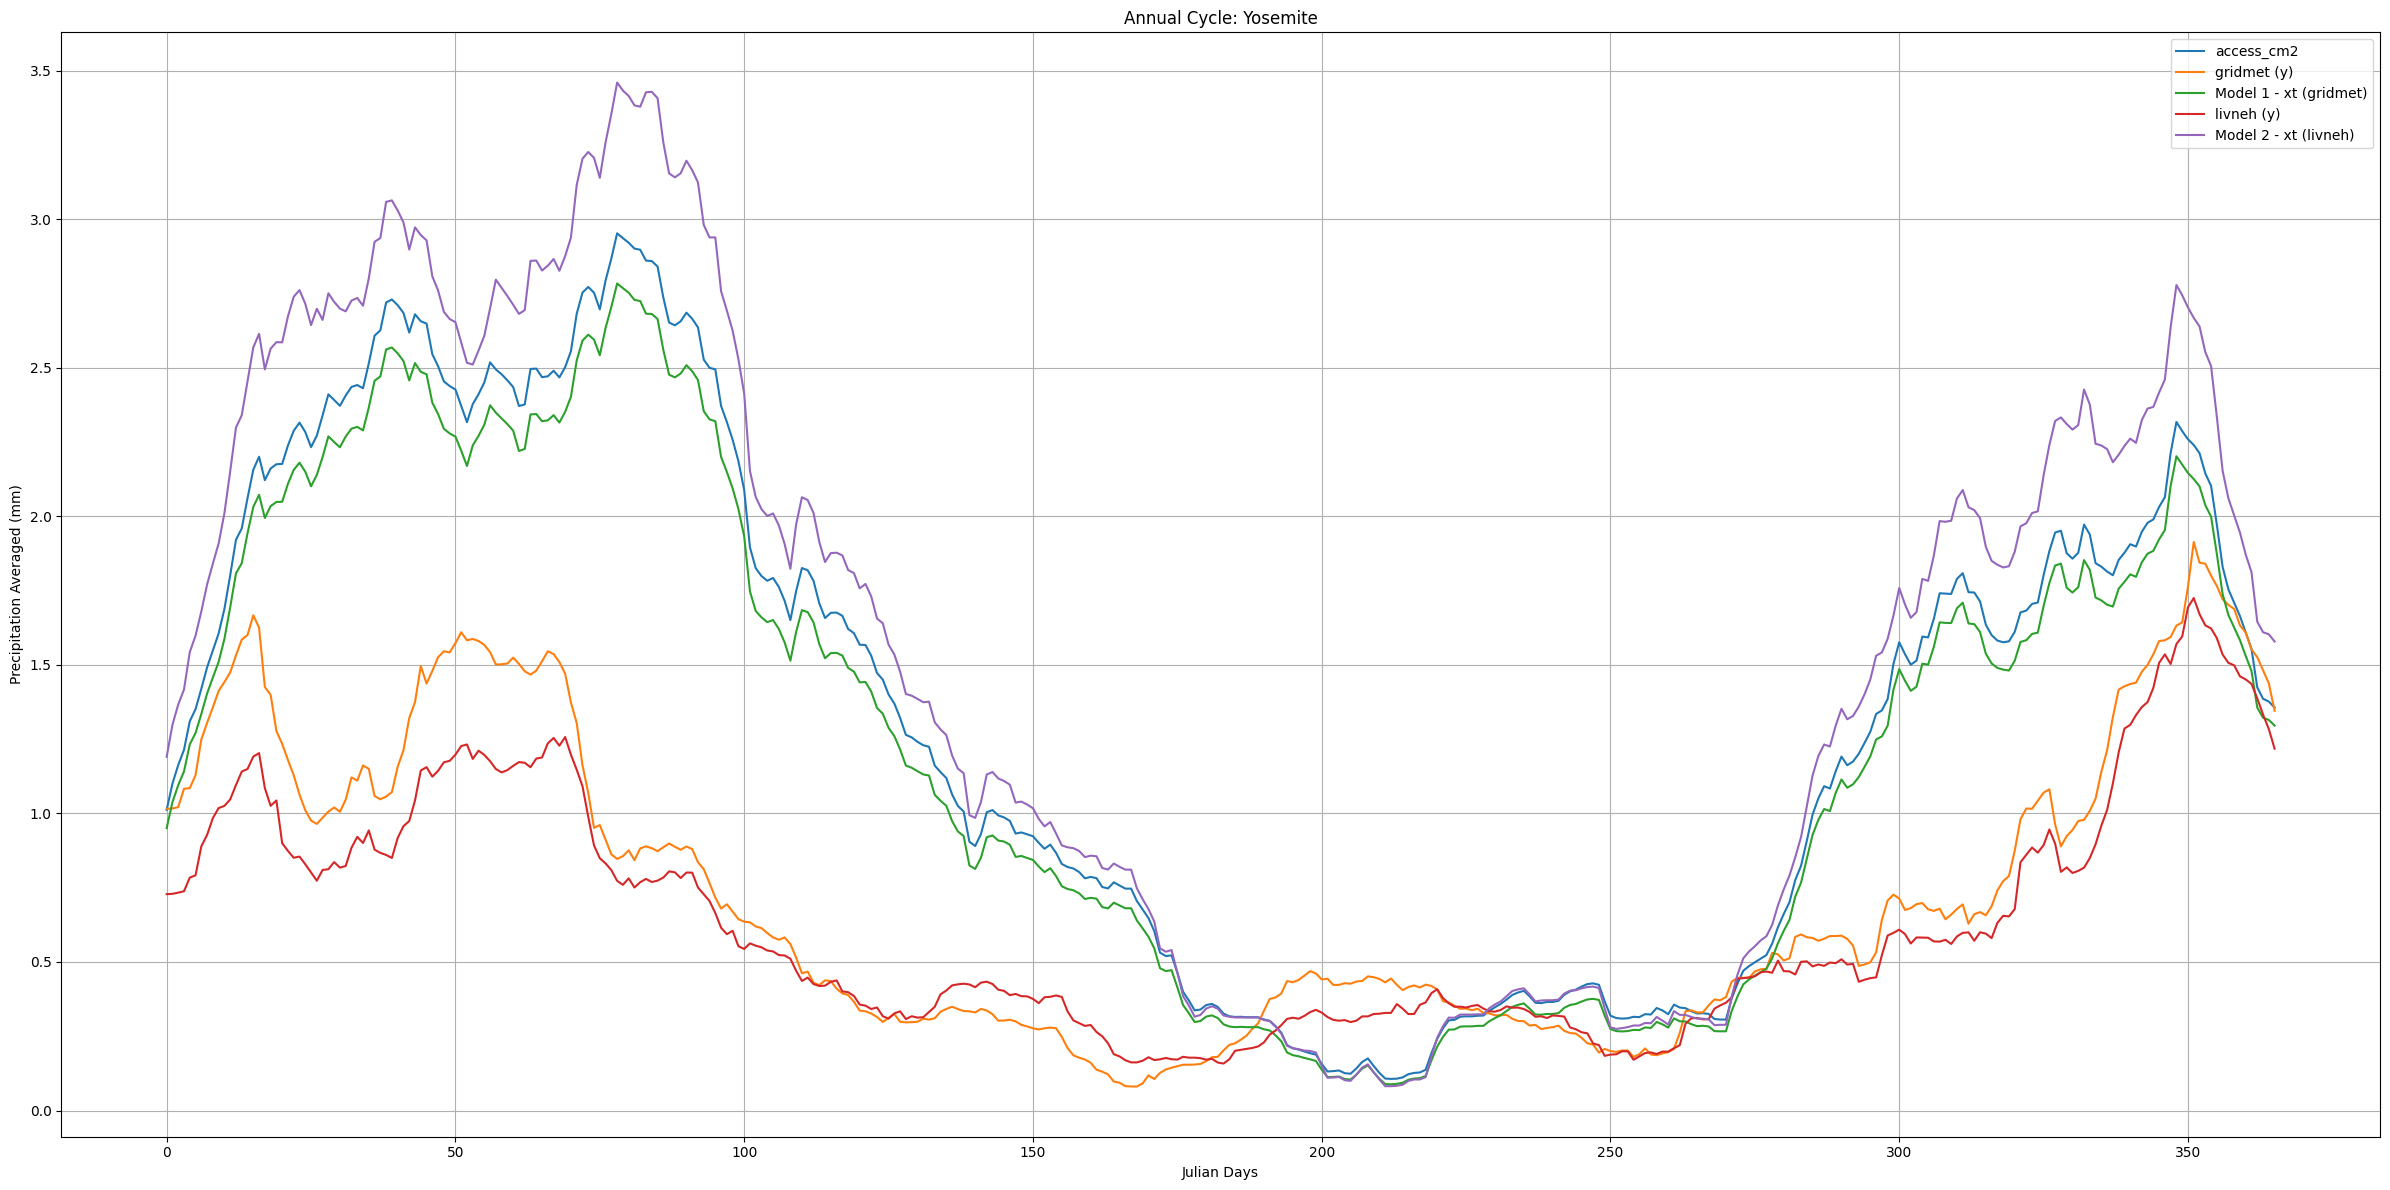

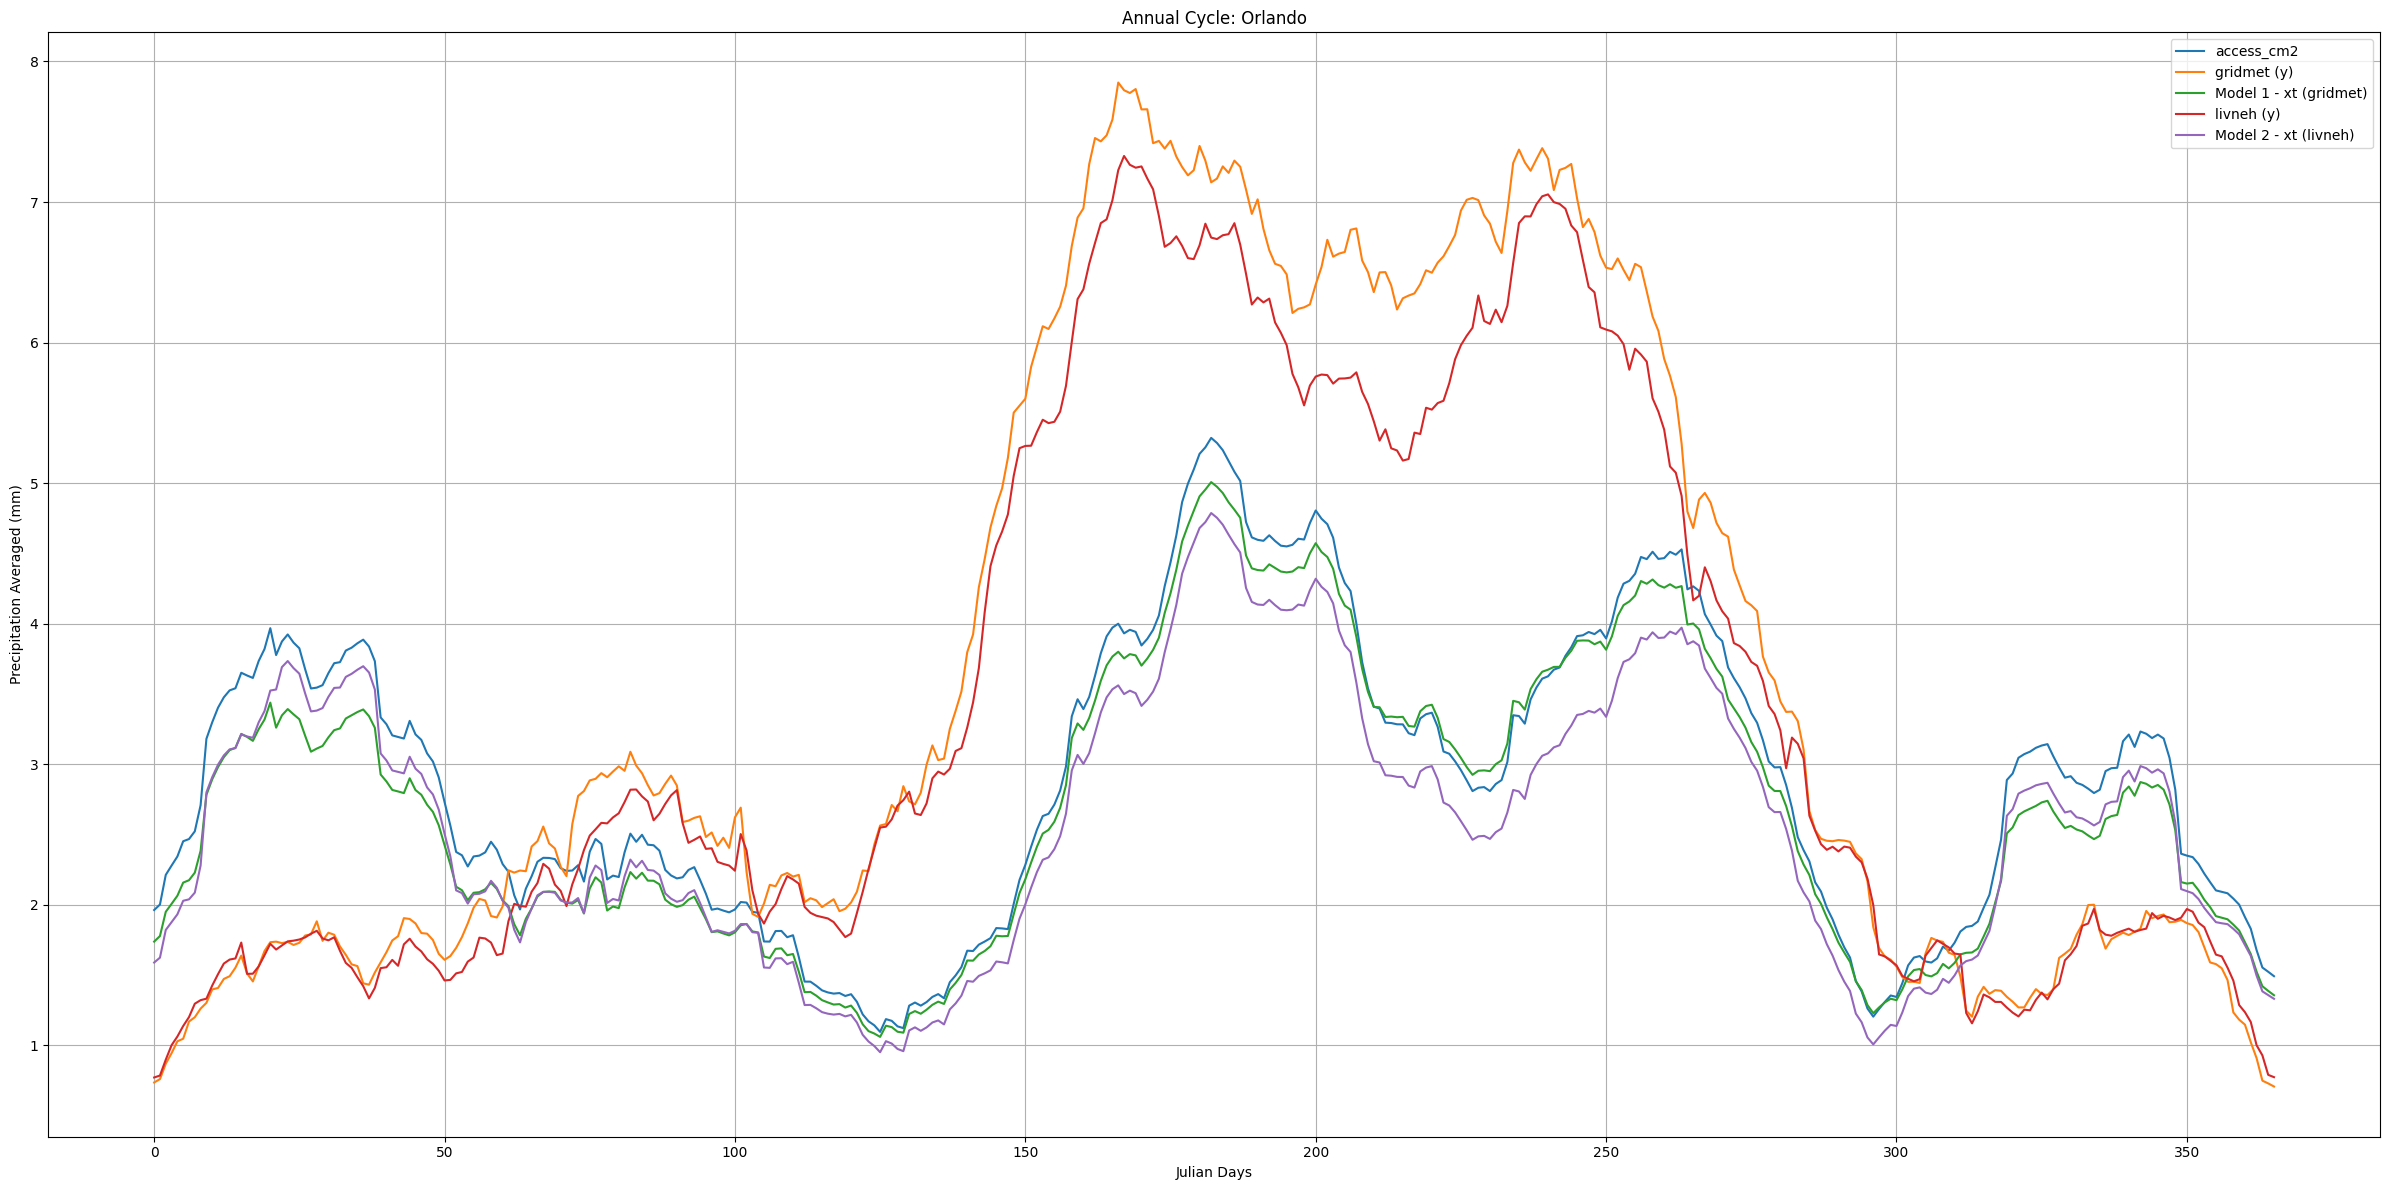

In [ ]:
def moving_average(arr, window=5):
    return np.convolve(arr, np.ones(window)/window, mode='same')

window_size = 30  # Adjust this as needed
scale = 'julian-day'
for j in range(len(cities)):

    time_labels = helper.extract_time_labels(models[0]['x_time_np'], label_type=scale)

    label_dummies = pd.get_dummies(time_labels)
    weights_np = label_dummies.div(label_dummies.sum(axis=0), axis=1).values.astype(np.float32)

    loc = nearest_indices[j]

    plt.figure(figsize=(24, 12))

    scaled_x = np.einsum('ts,tm->sm', models[0]['x'] , weights_np)  # (sites, scale)
    clim_label = models[0]['config']['clim']

    smoothed_x = moving_average(scaled_x[loc], window_size)
    # mean_x = scaled_x.mean(axis=0)
    # smoothed_x = moving_average(mean_x, window_size)

    plt.plot(smoothed_x, label=f'{clim_label}')



    for i in range(len(models)):
        # weights_np.shape
        scaled_y = np.einsum('ts,tm->sm', models[i]['y'] , weights_np)  # (sites, scale)
        scaled_xt = np.einsum('ts,tm->sm', models[i]['xt'] , weights_np)  # (sites, scale)

        ref_label = models[i]['config']['ref']

        # You can average across sites to reduce to 1D curves:
        # mean_y = scaled_y.mean(axis=0)
        # mean_xt = scaled_xt.mean(axis=0)
        
        # Apply moving average to the first site's data
        smoothed_y = moving_average(scaled_y[loc], window_size)
        smoothed_xt = moving_average(scaled_xt[loc], window_size)

        # smoothed_y = moving_average(mean_y, window_size)
        # smoothed_xt = moving_average(mean_xt, window_size)

        plt.plot(smoothed_y, label=f'{ref_label} (y)')
        plt.plot(smoothed_xt, label=f'Model {i+1} - xt ({ref_label})')


    plt.xlabel(scale)
    plt.ylabel('Precipitation Averaged (mm)')
    plt.title(f'Annual Cycle: {list(cities.keys())[j]}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


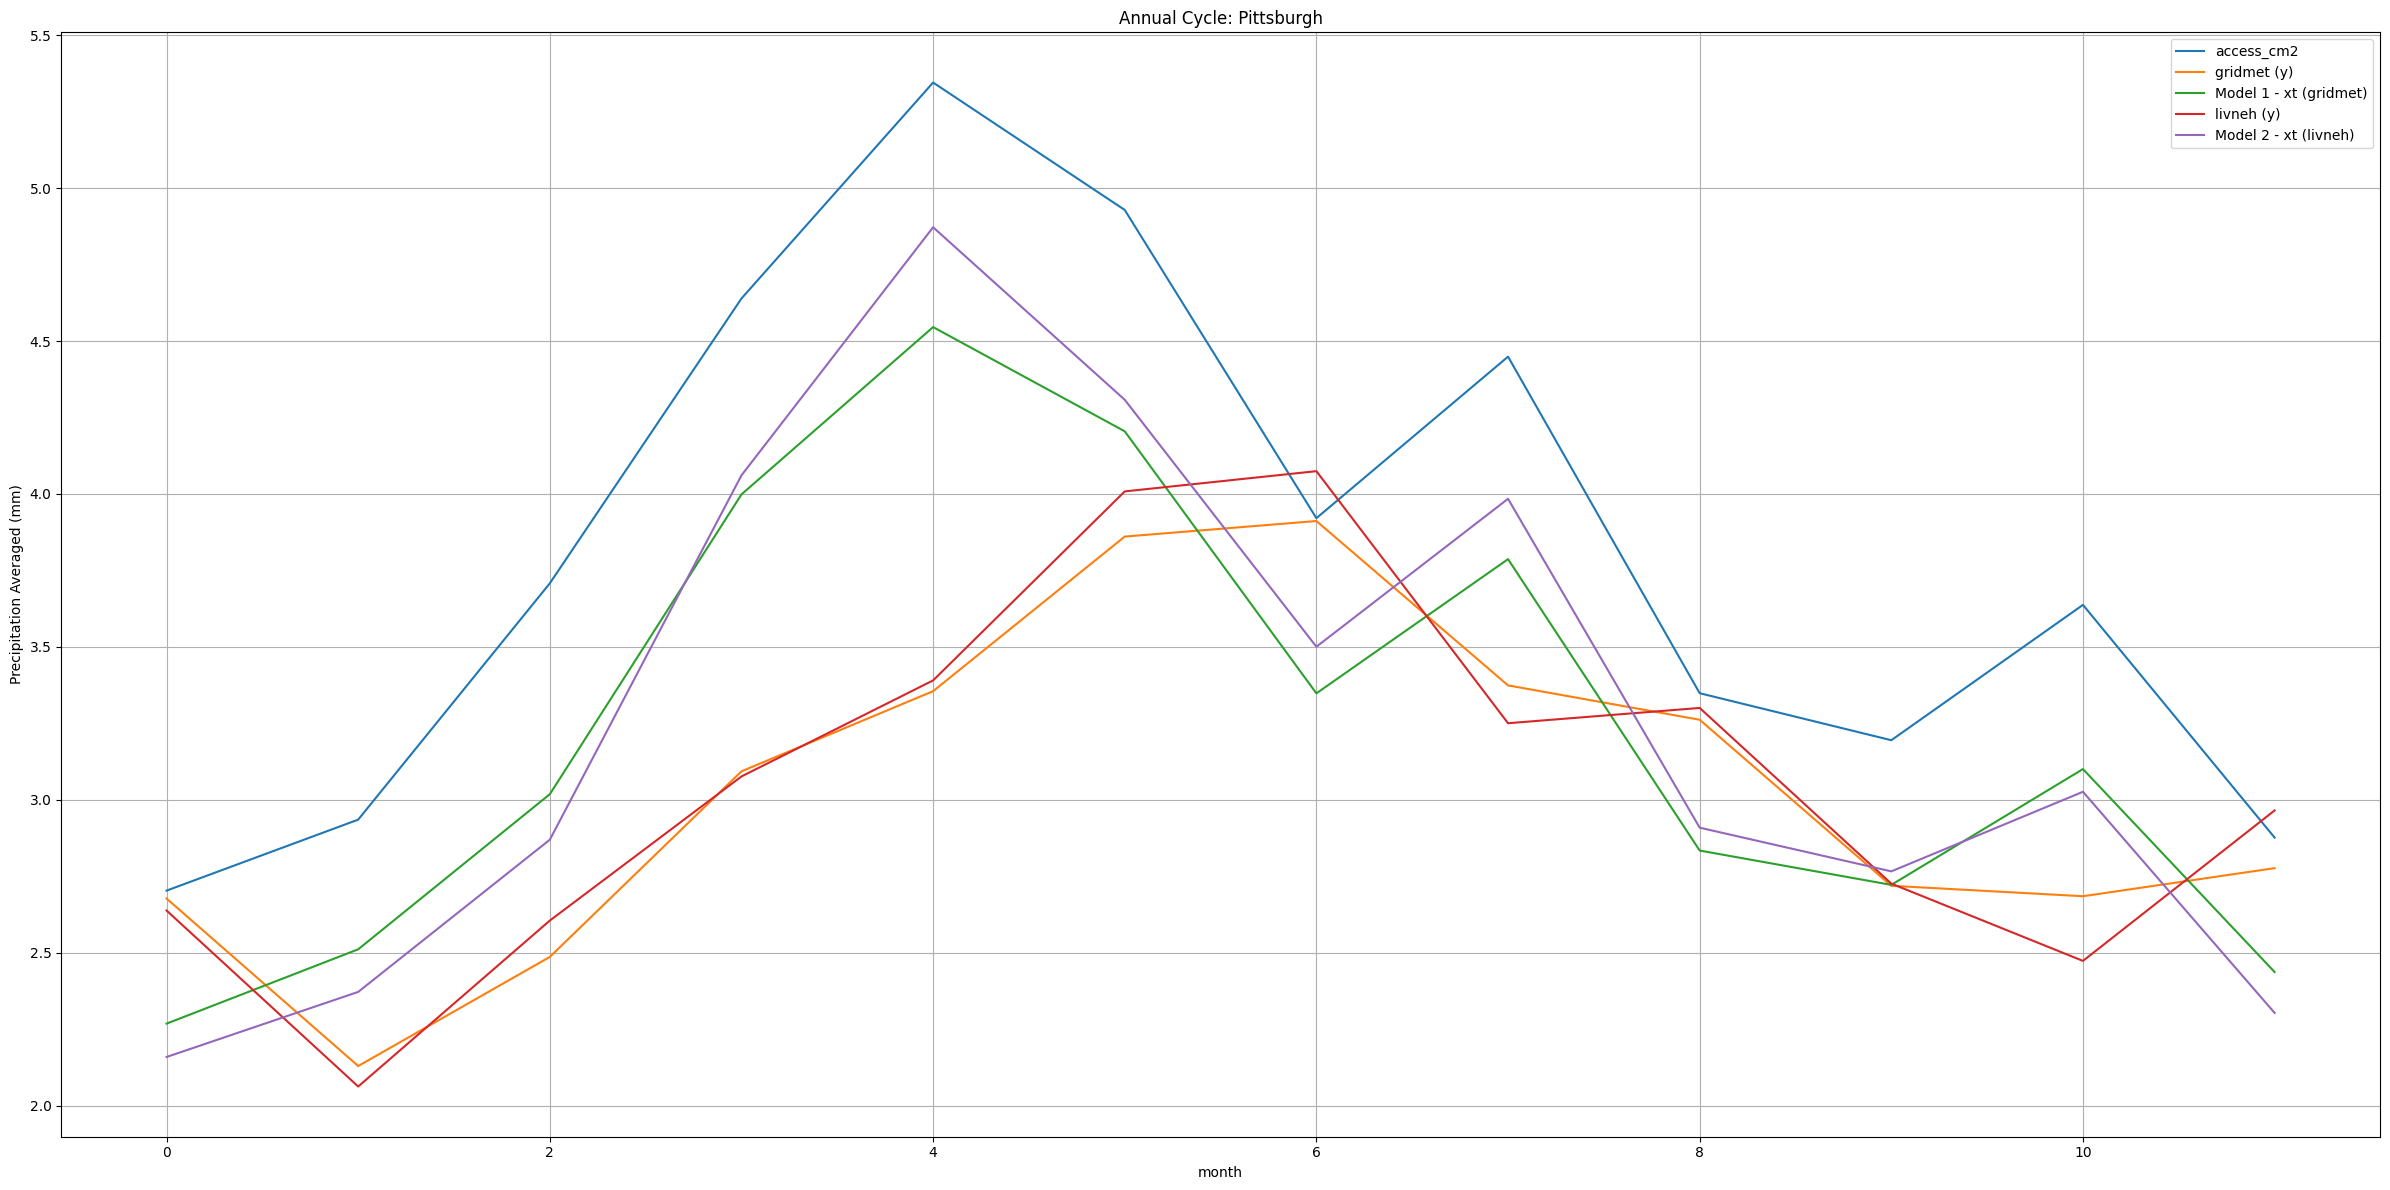

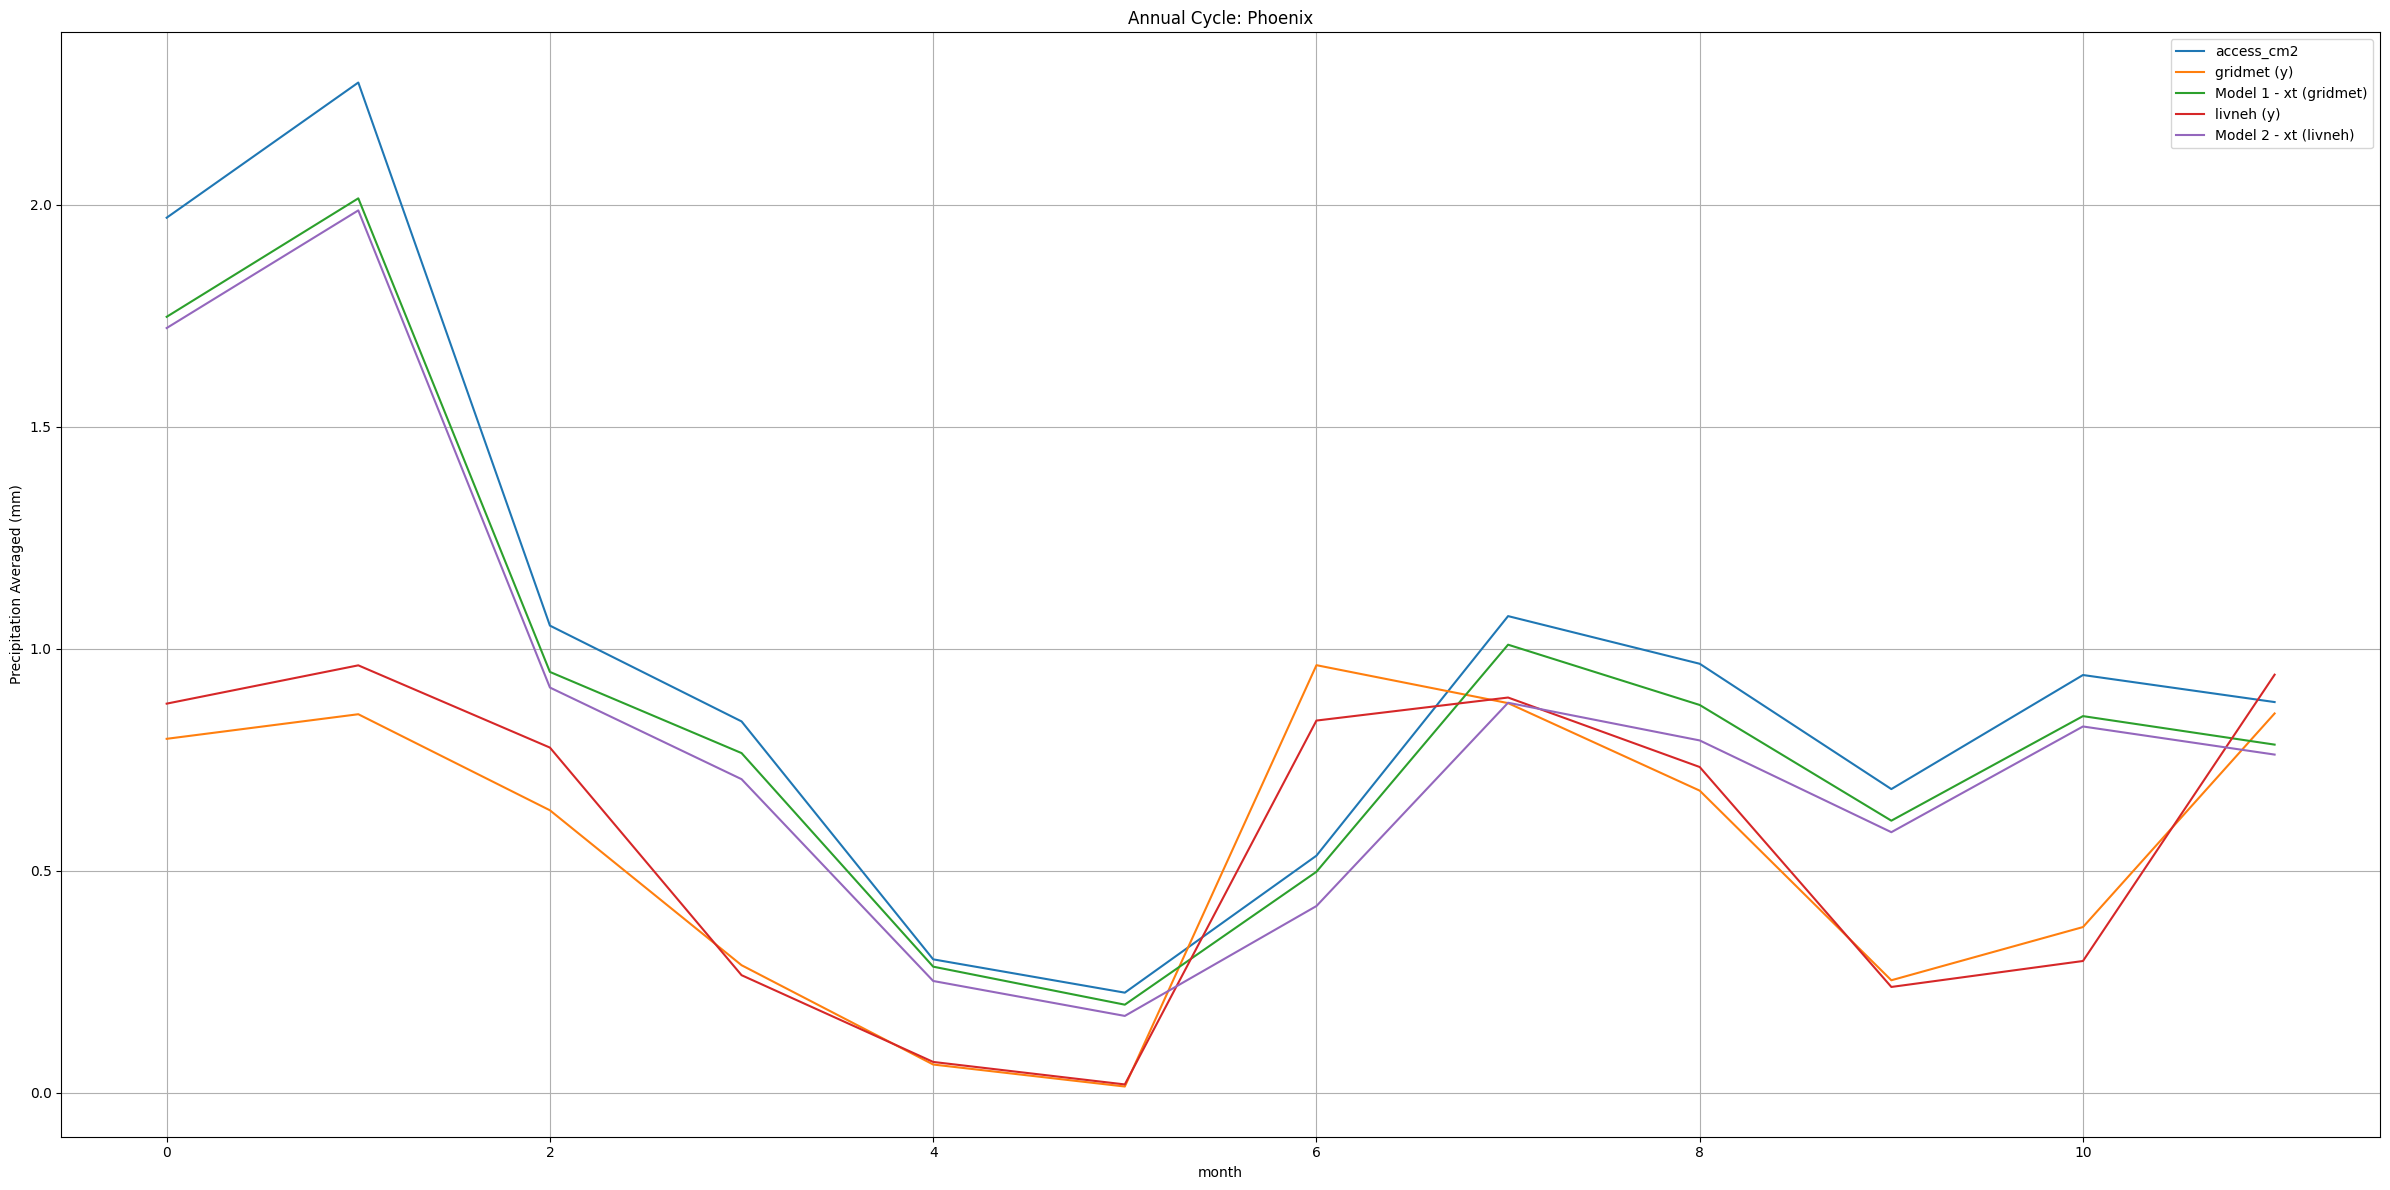

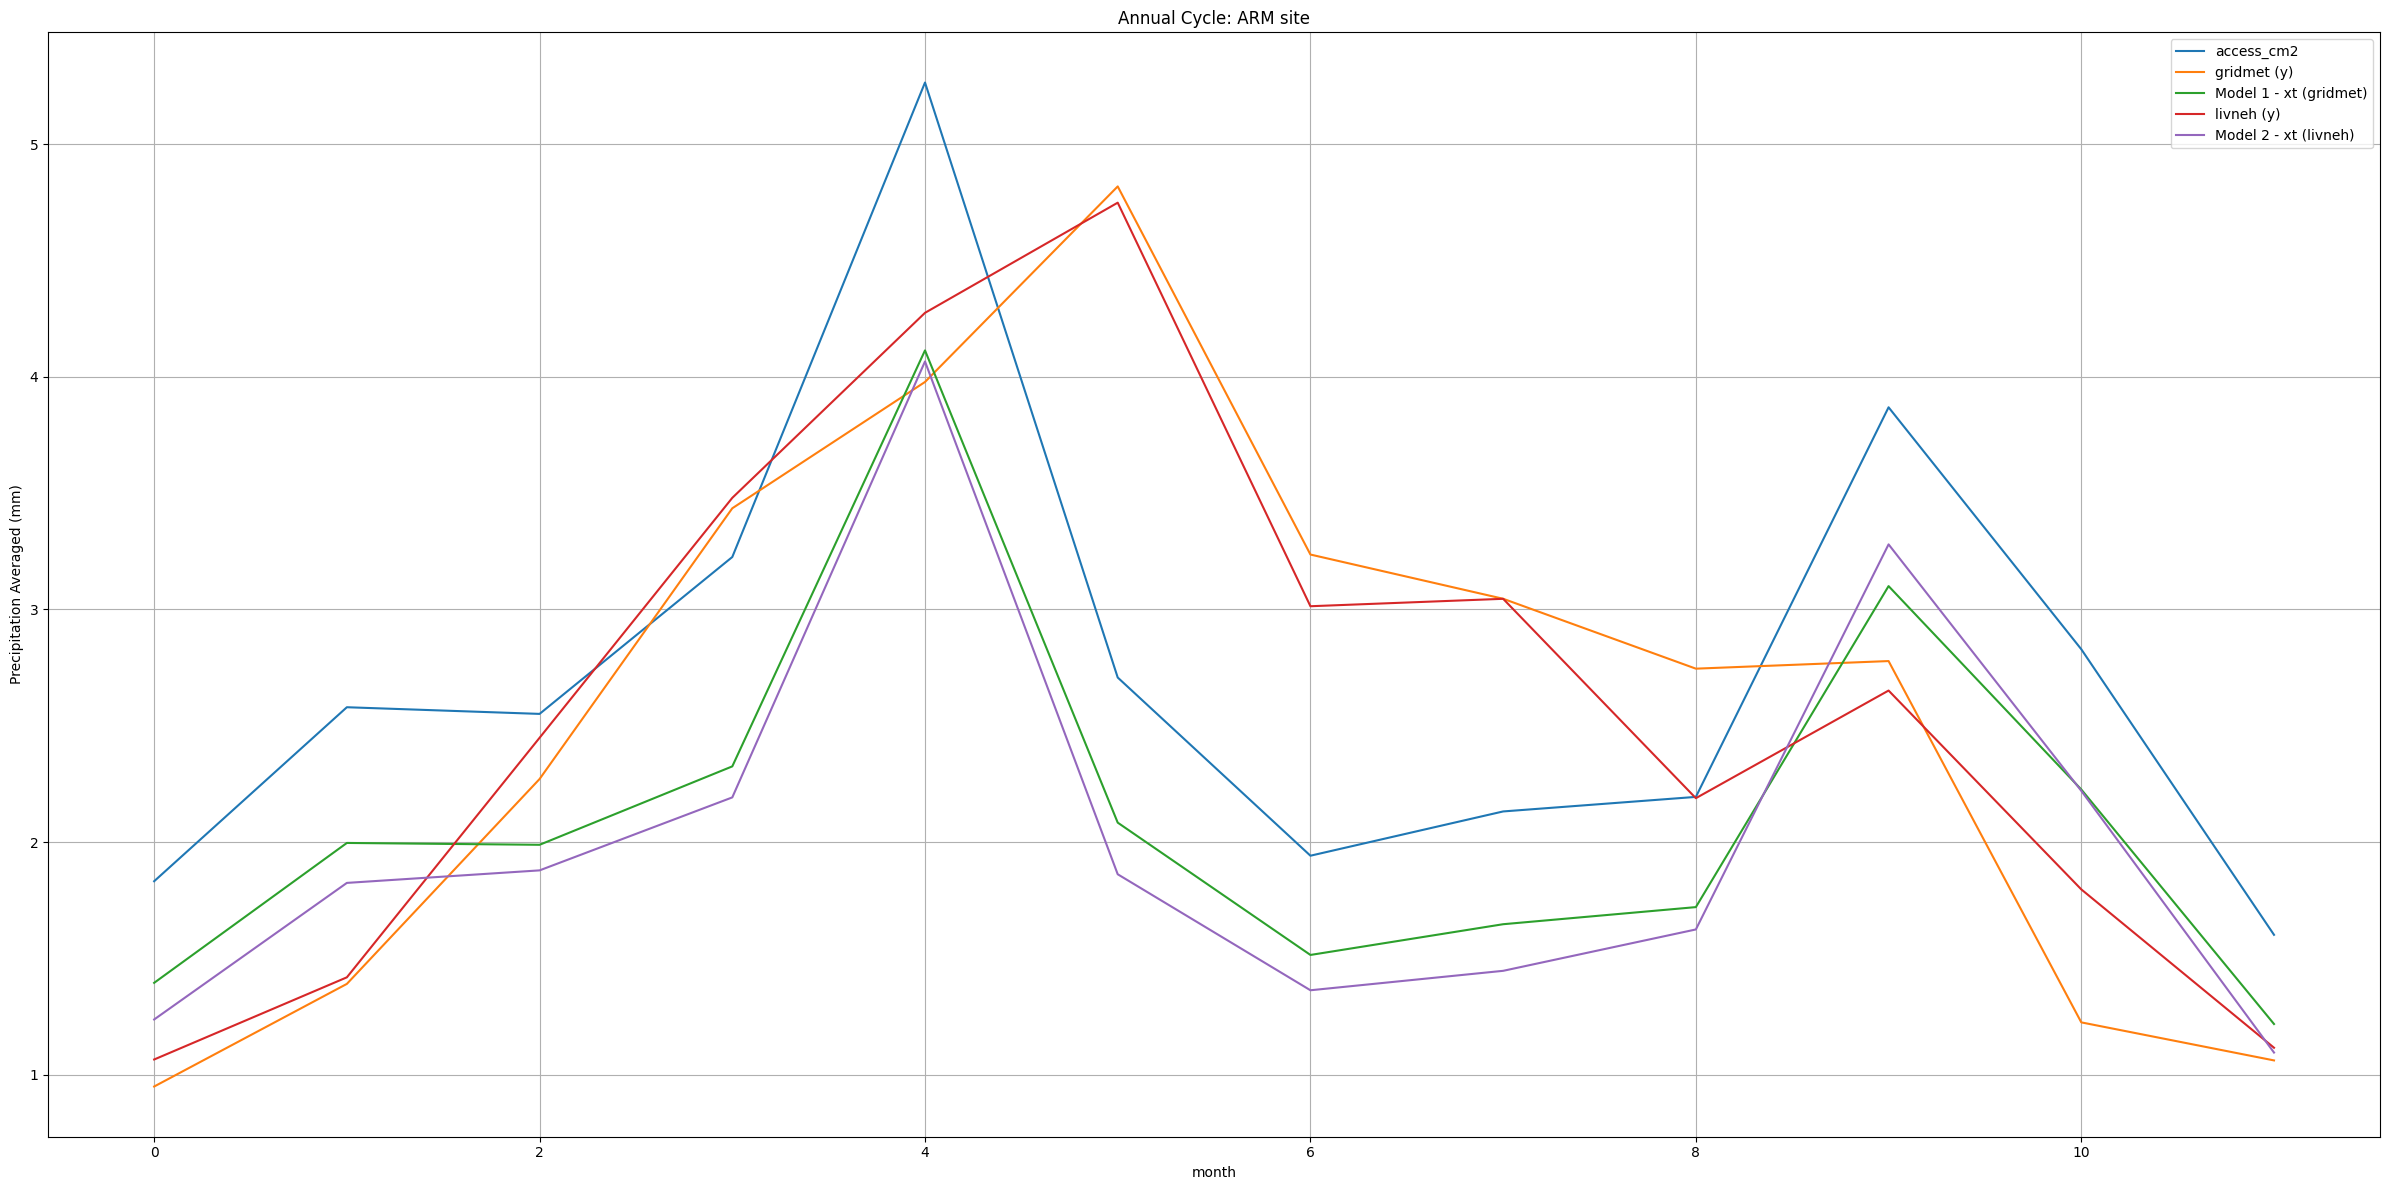

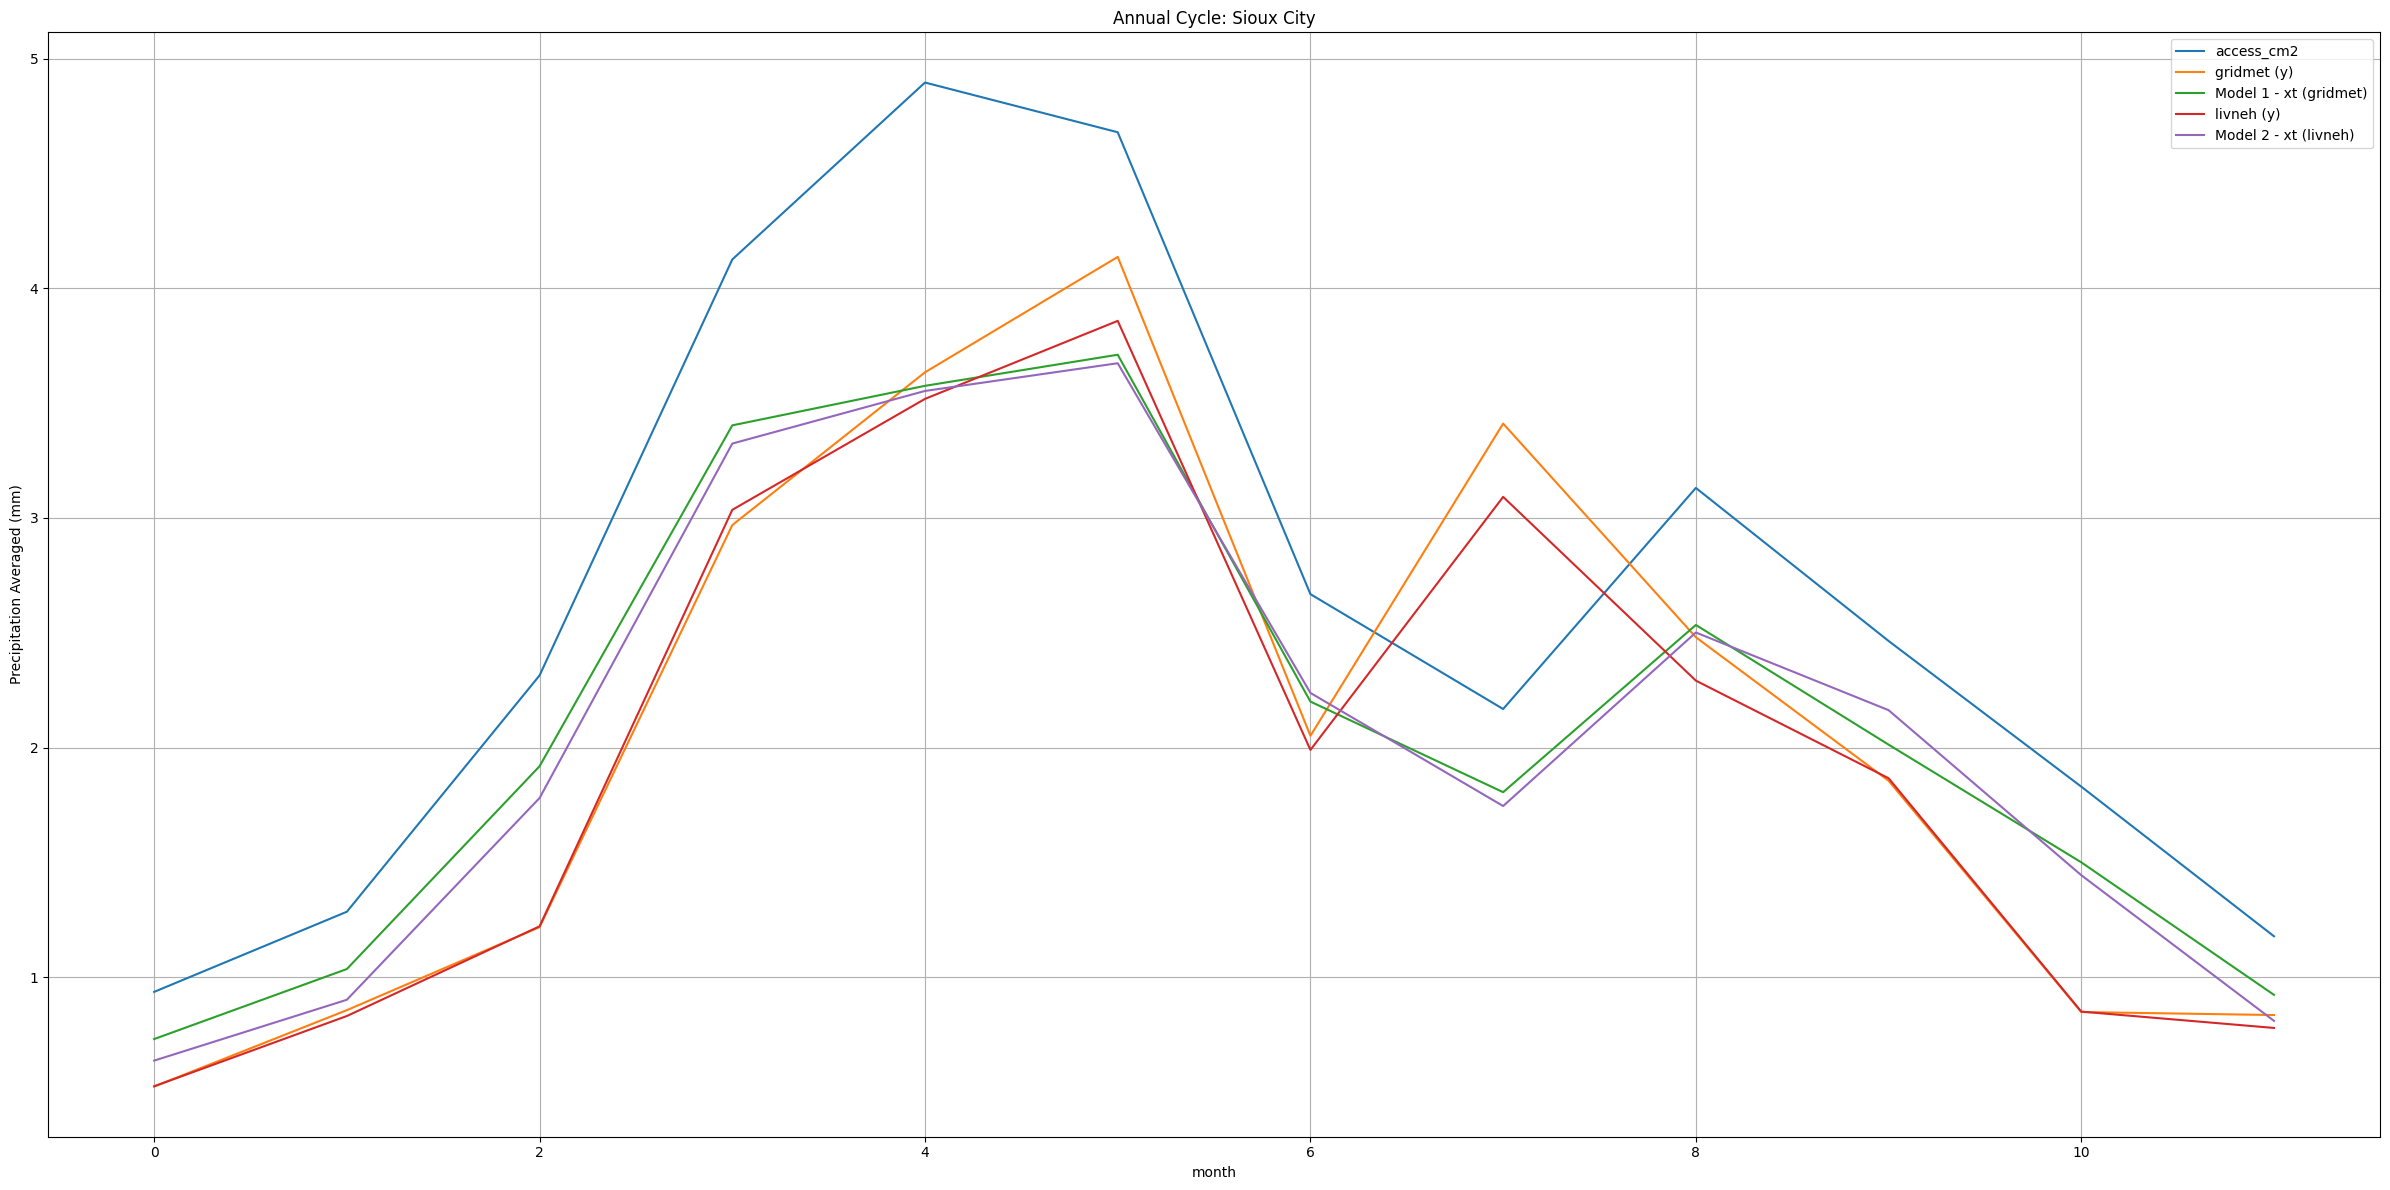

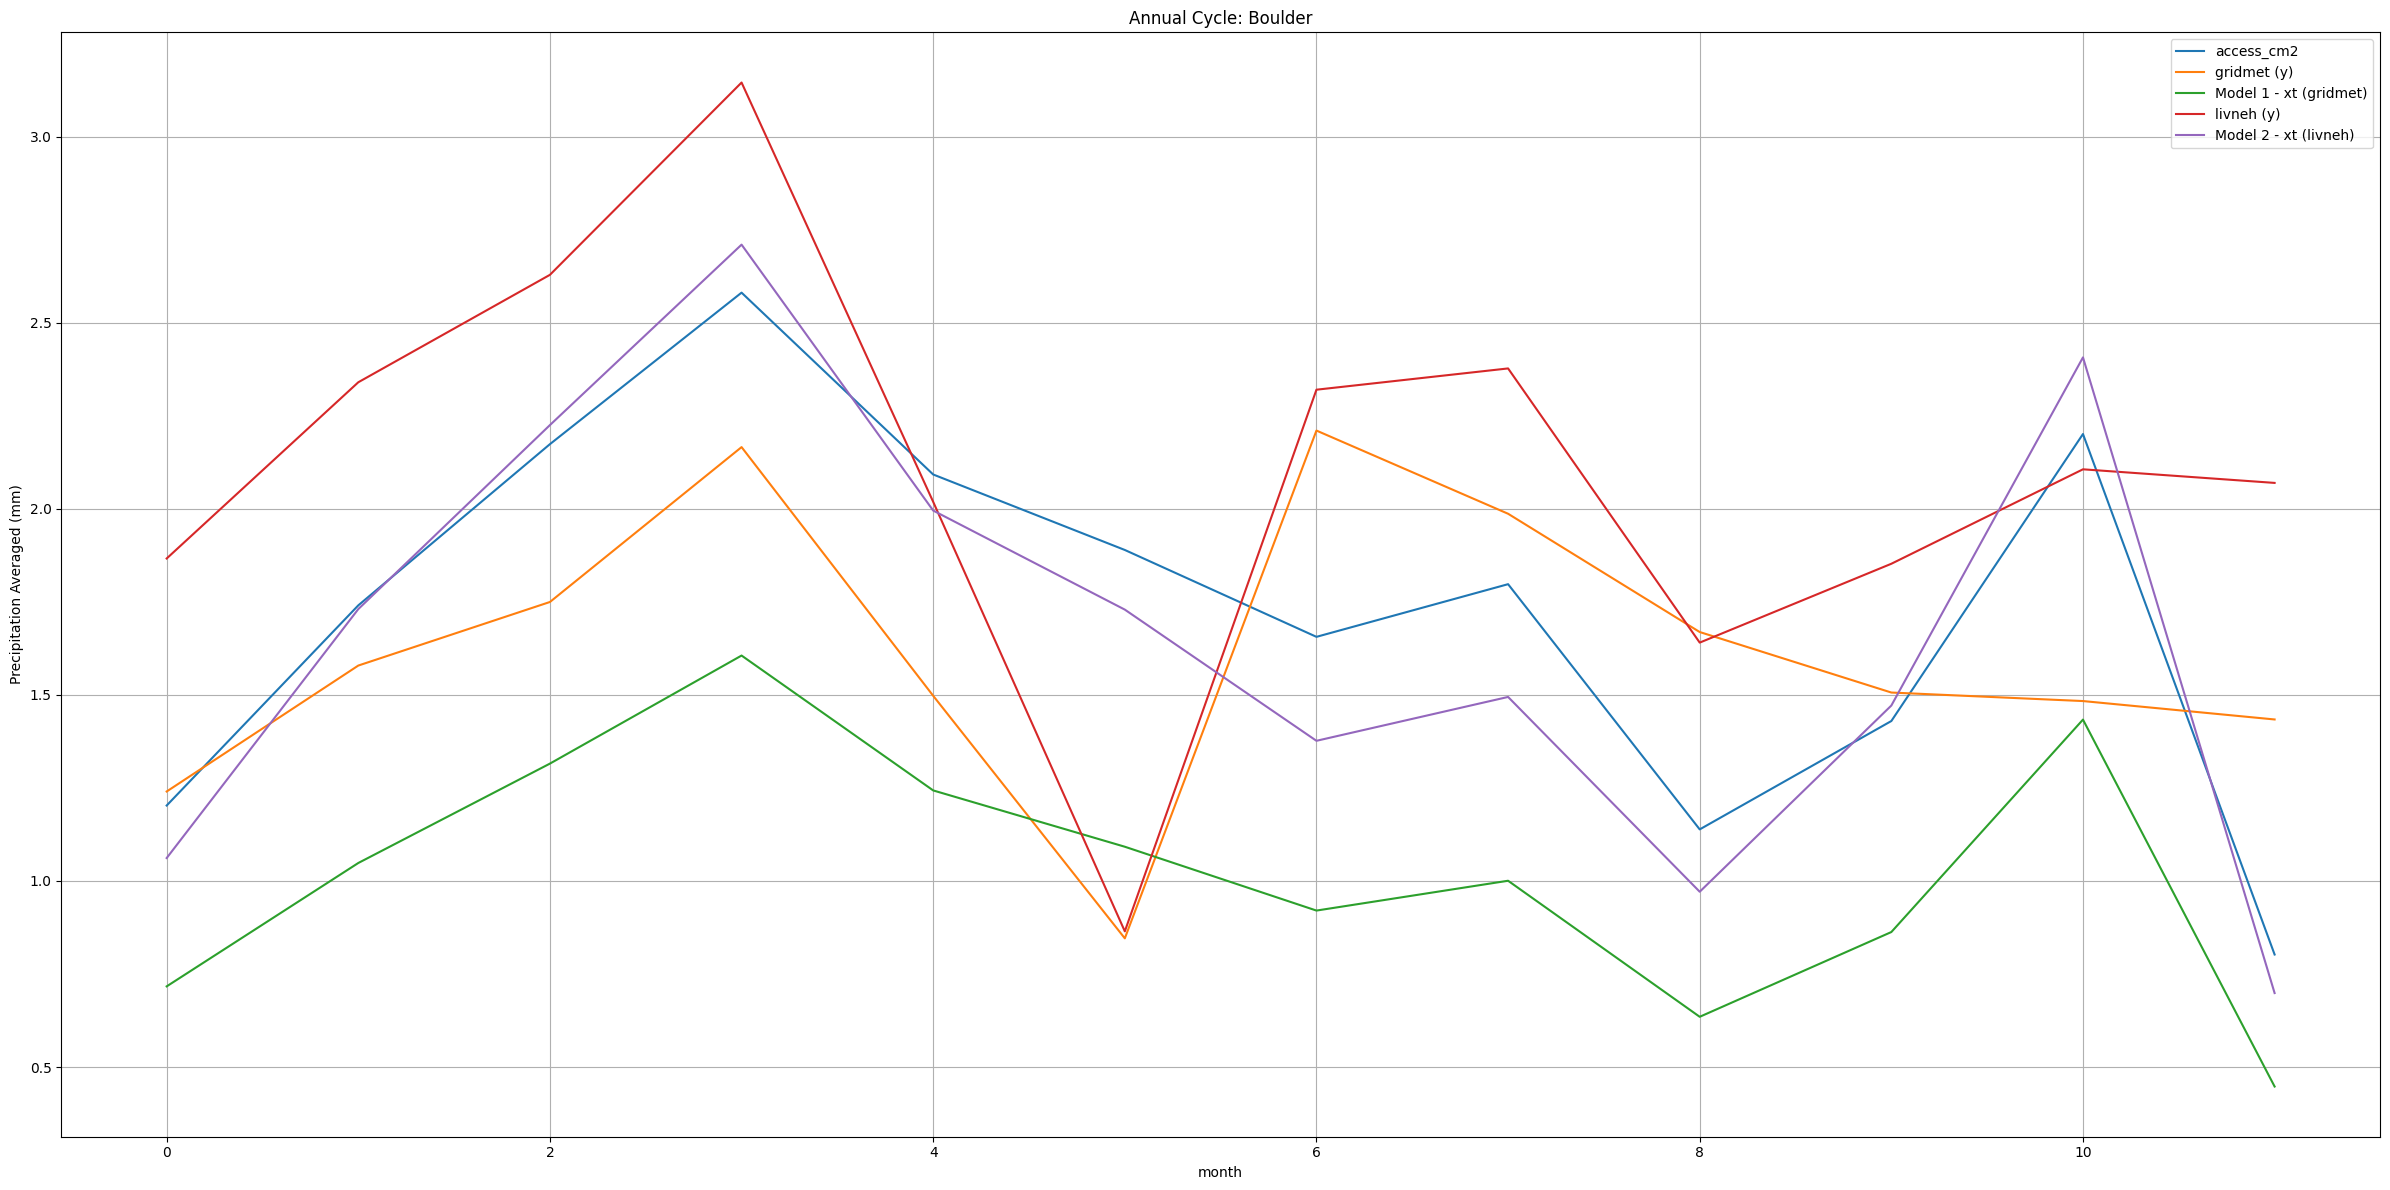

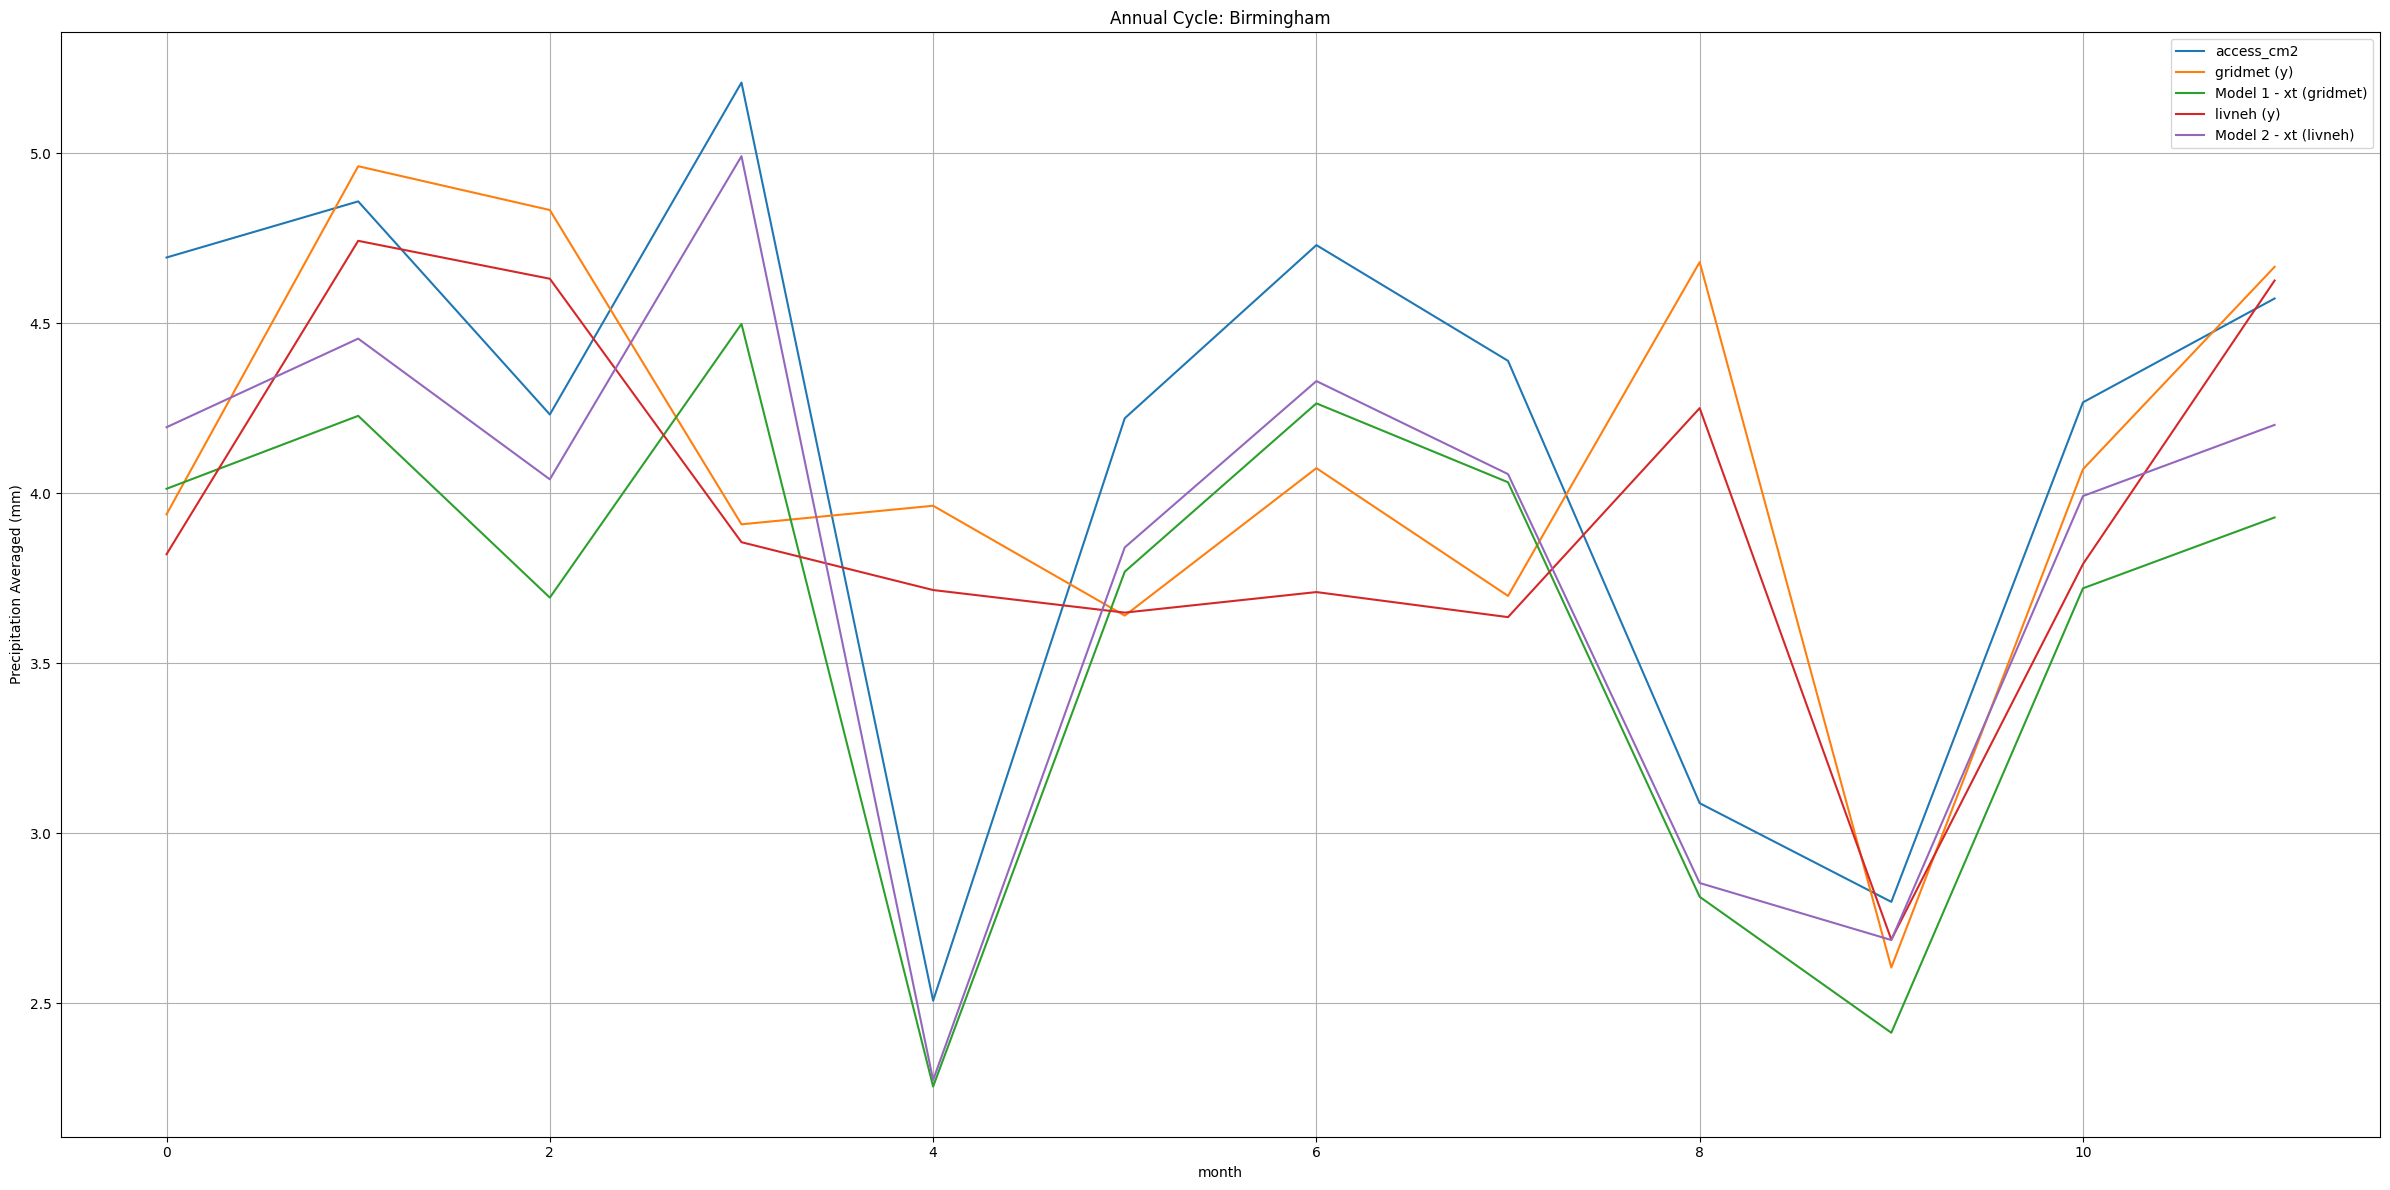

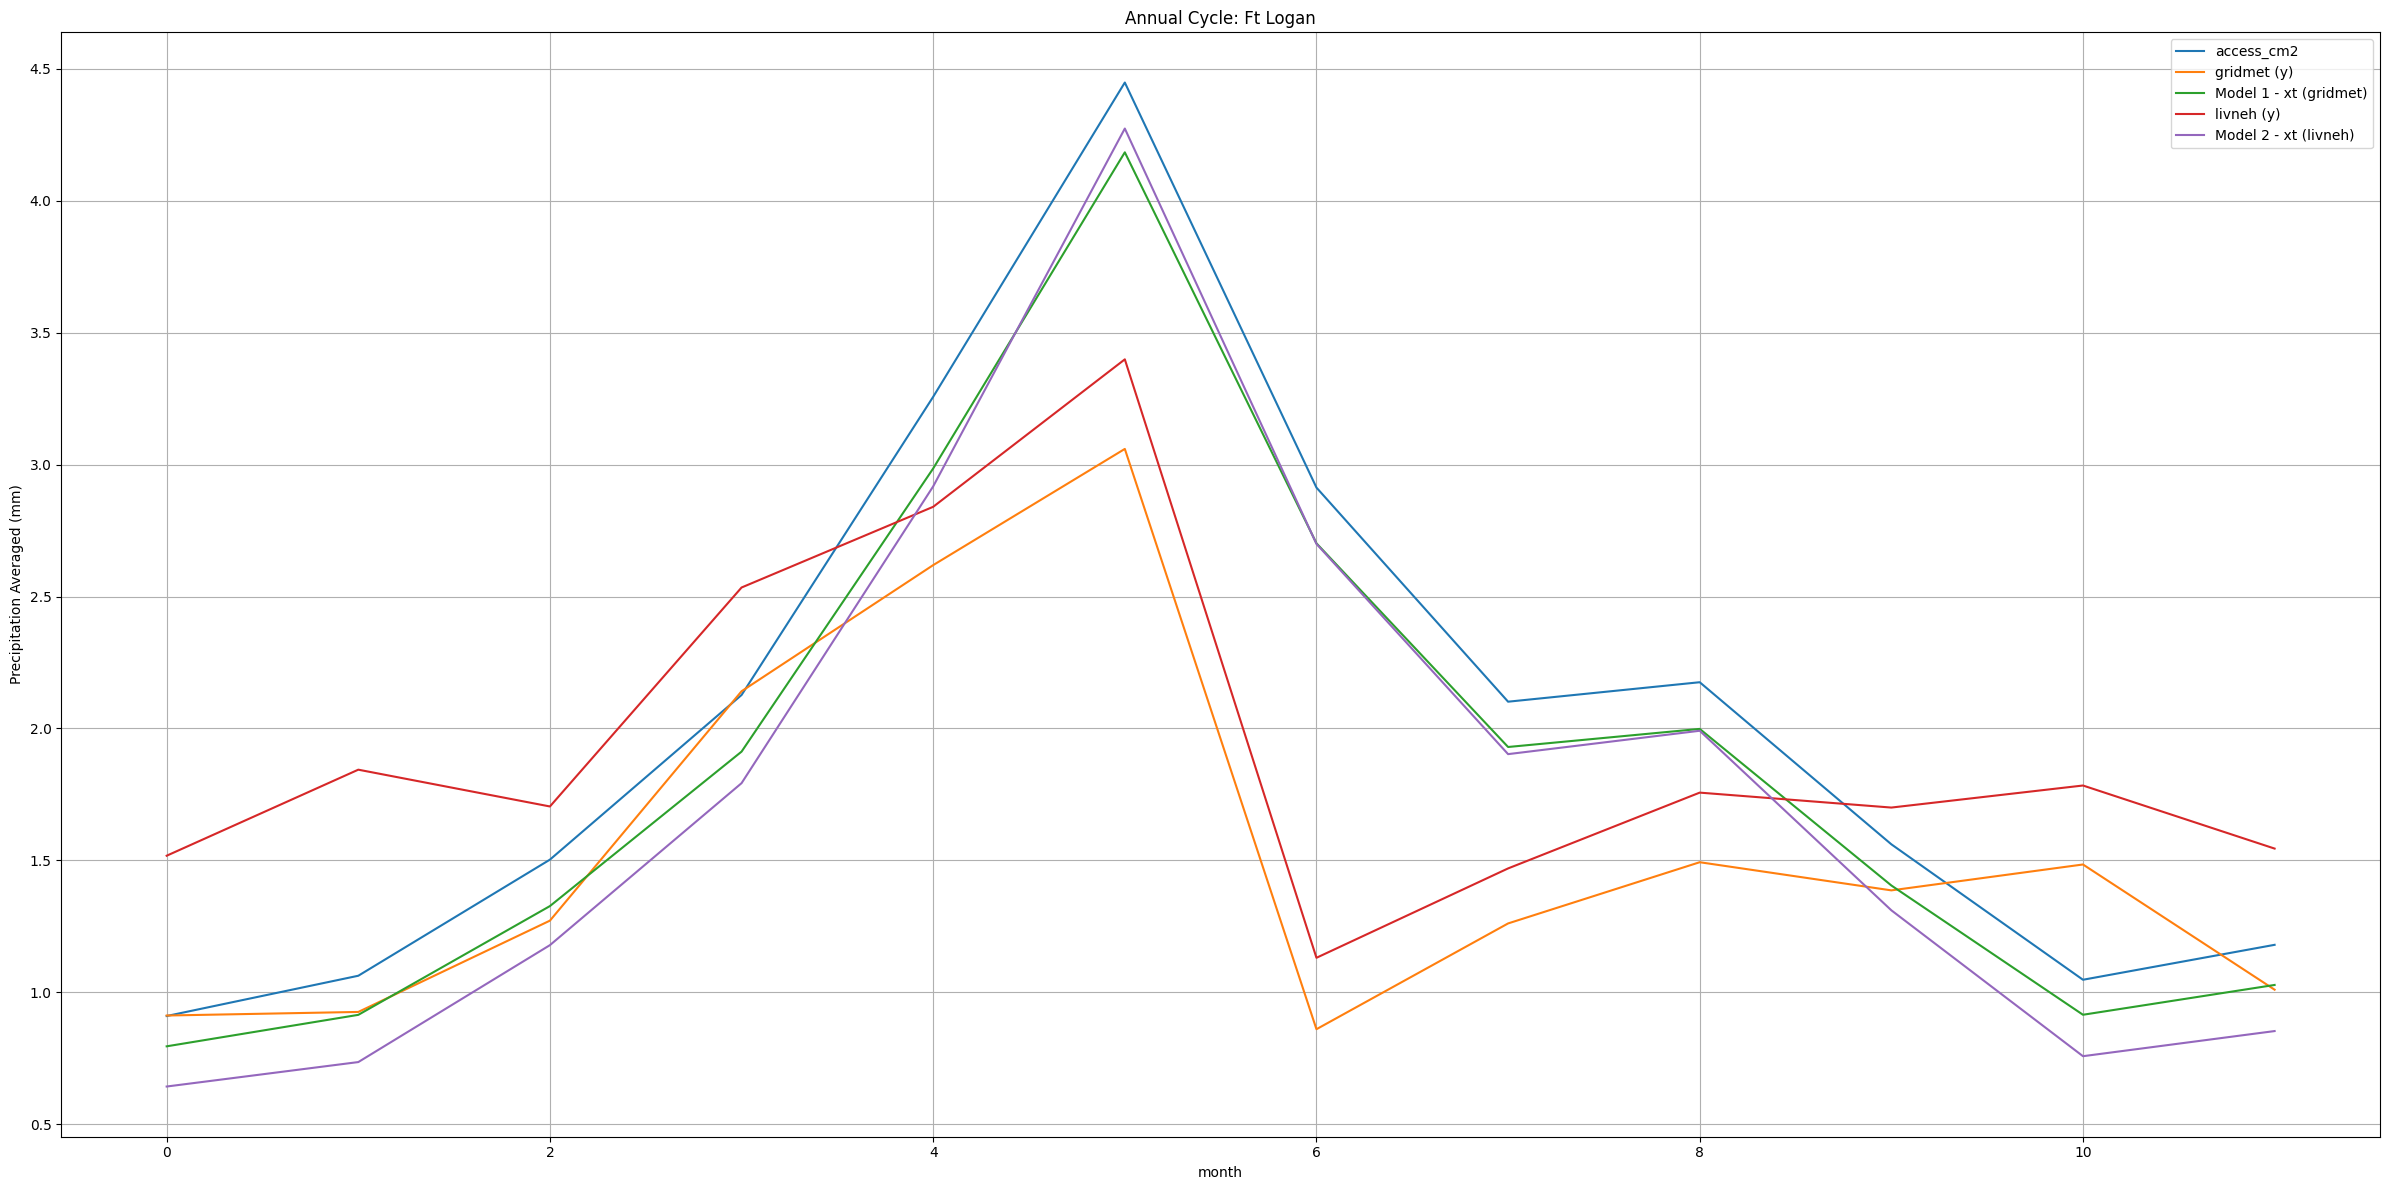

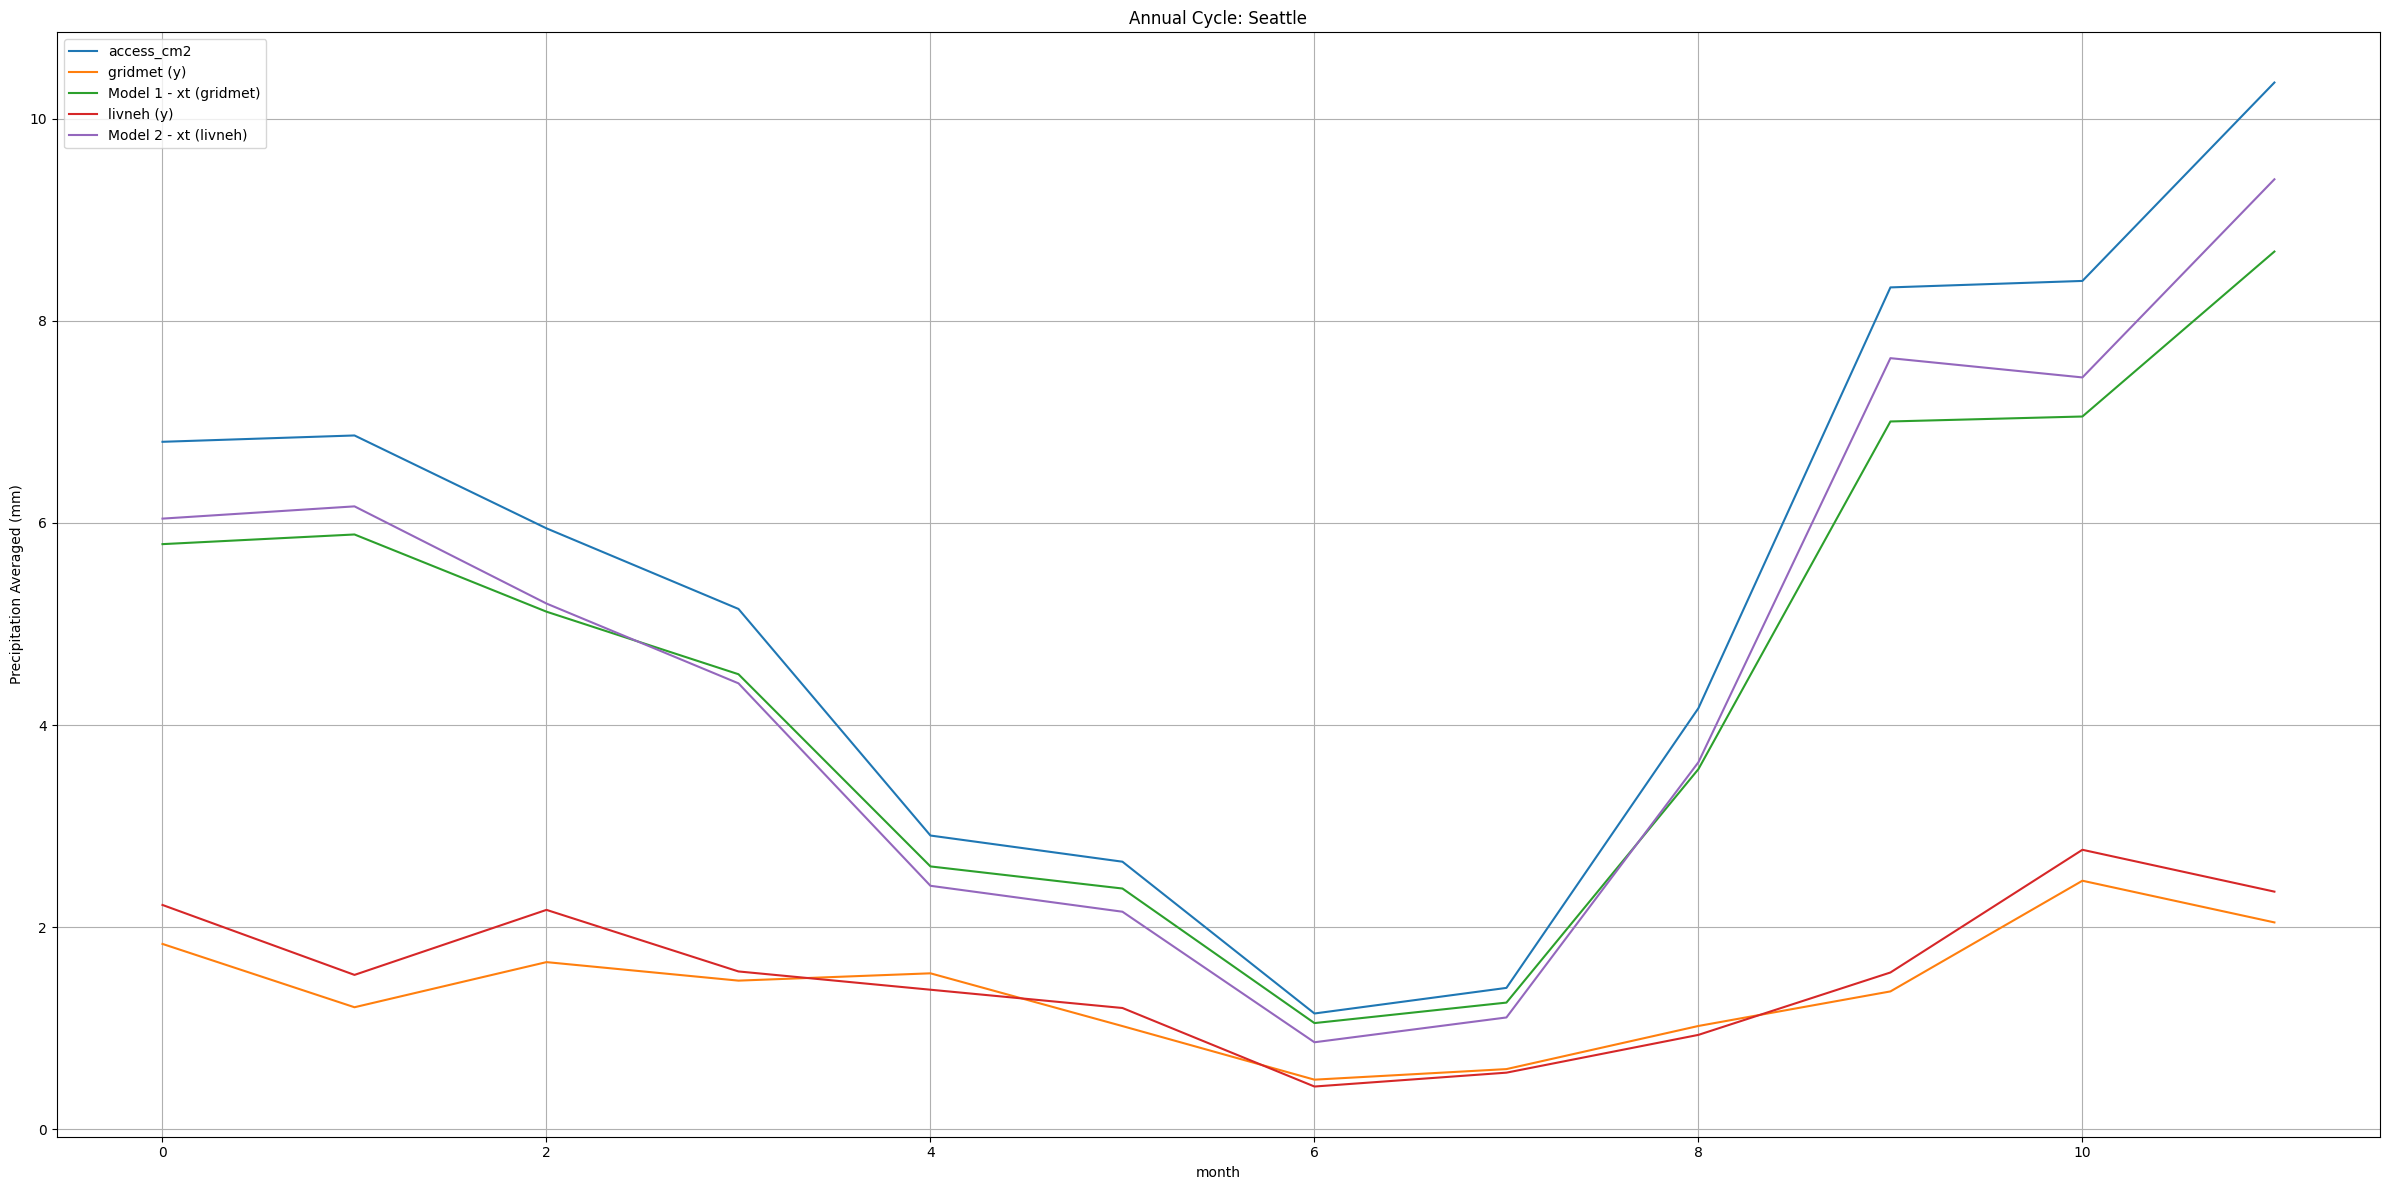

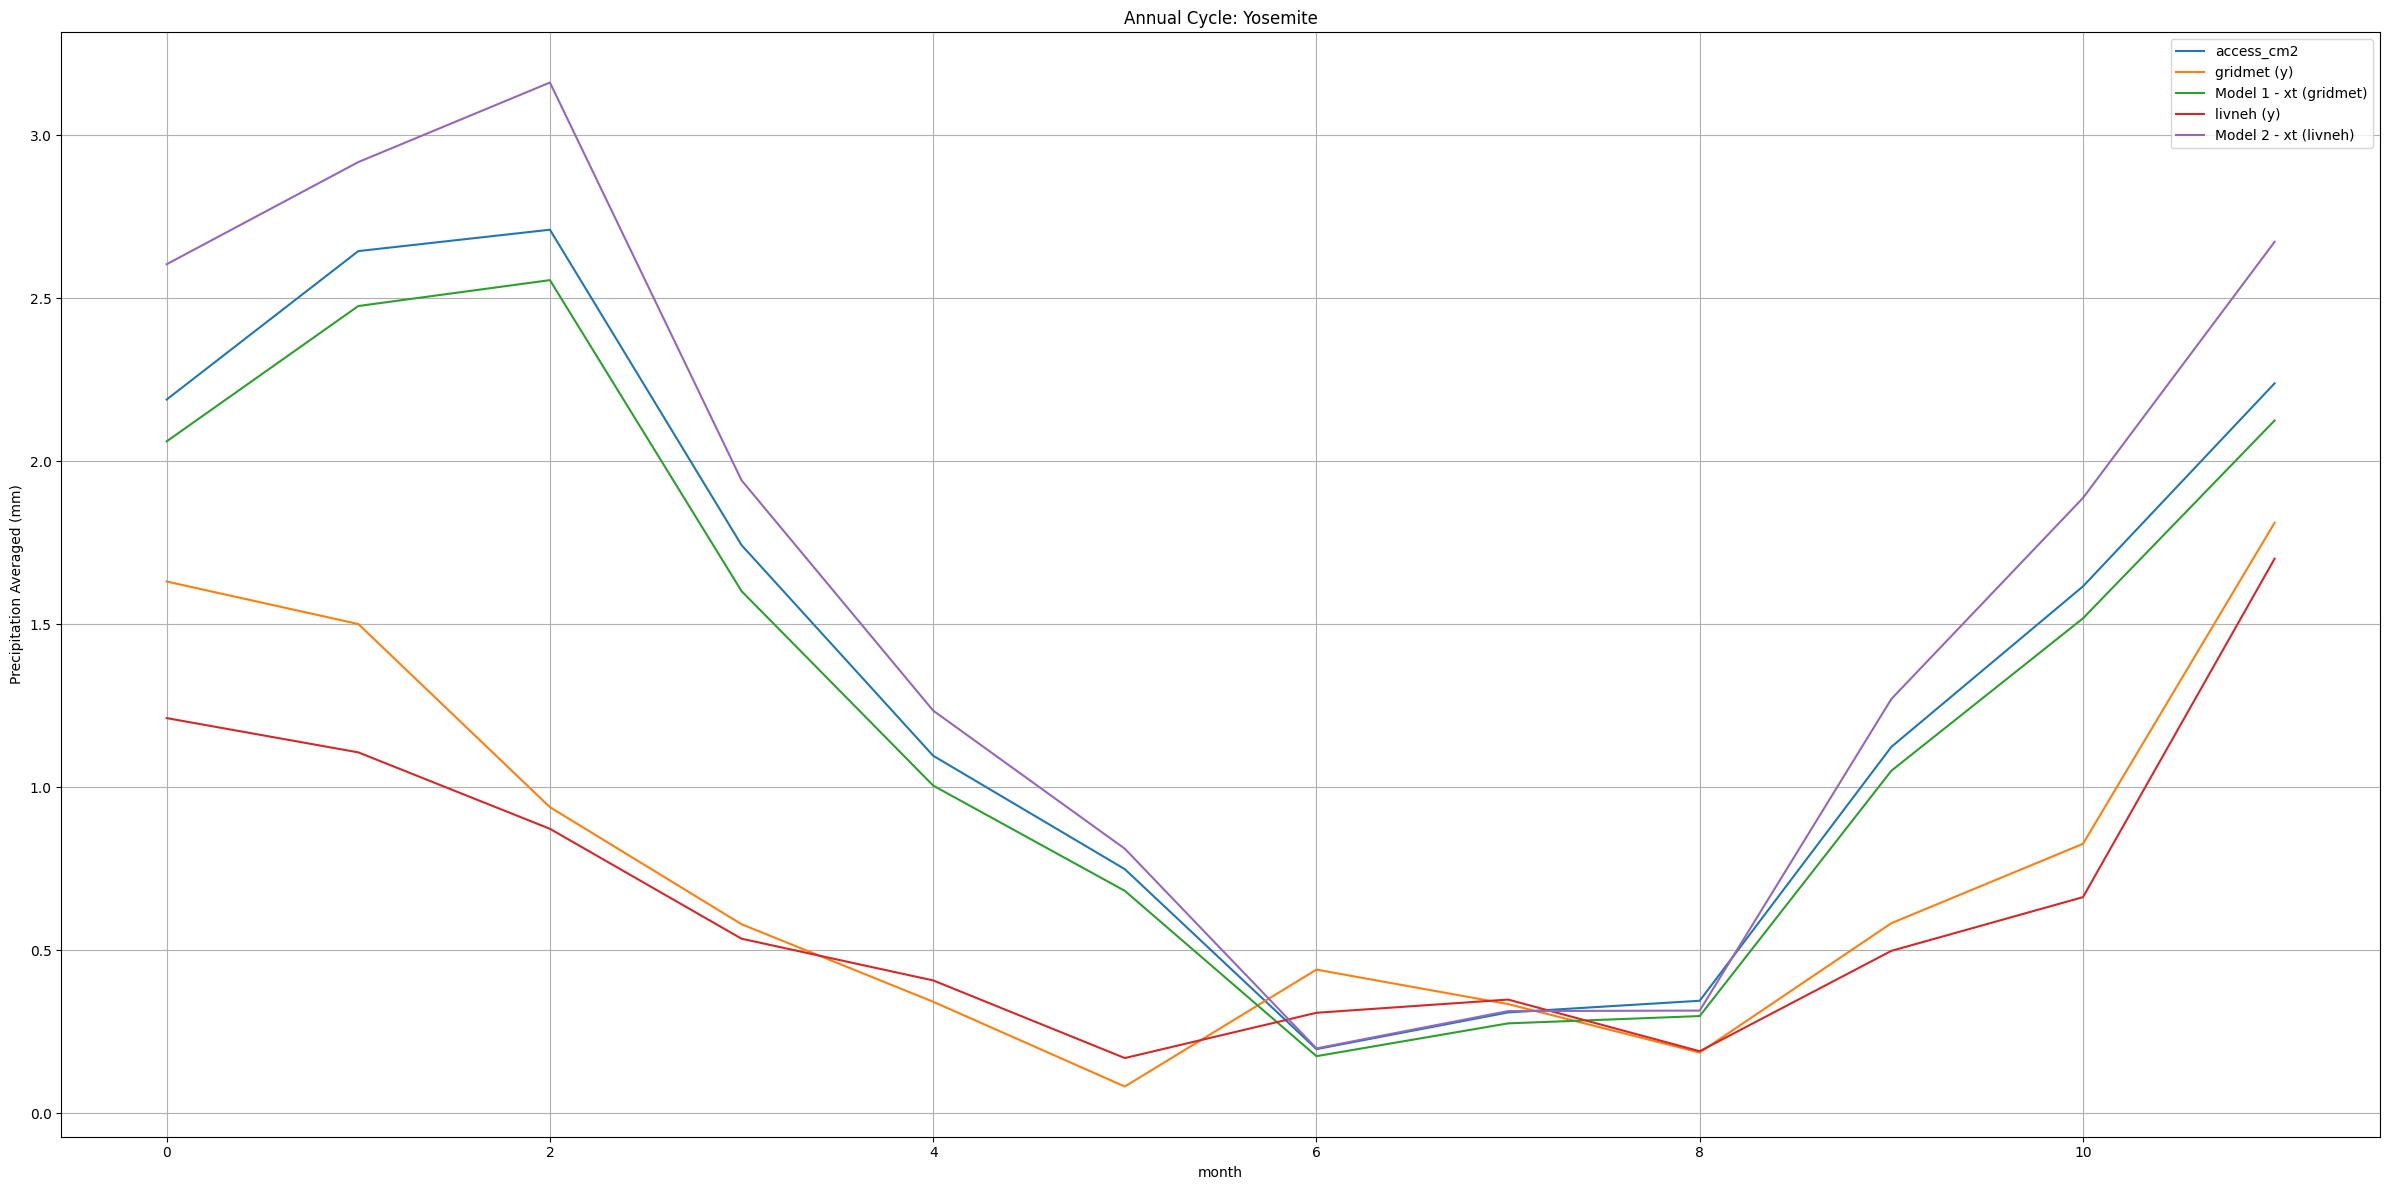

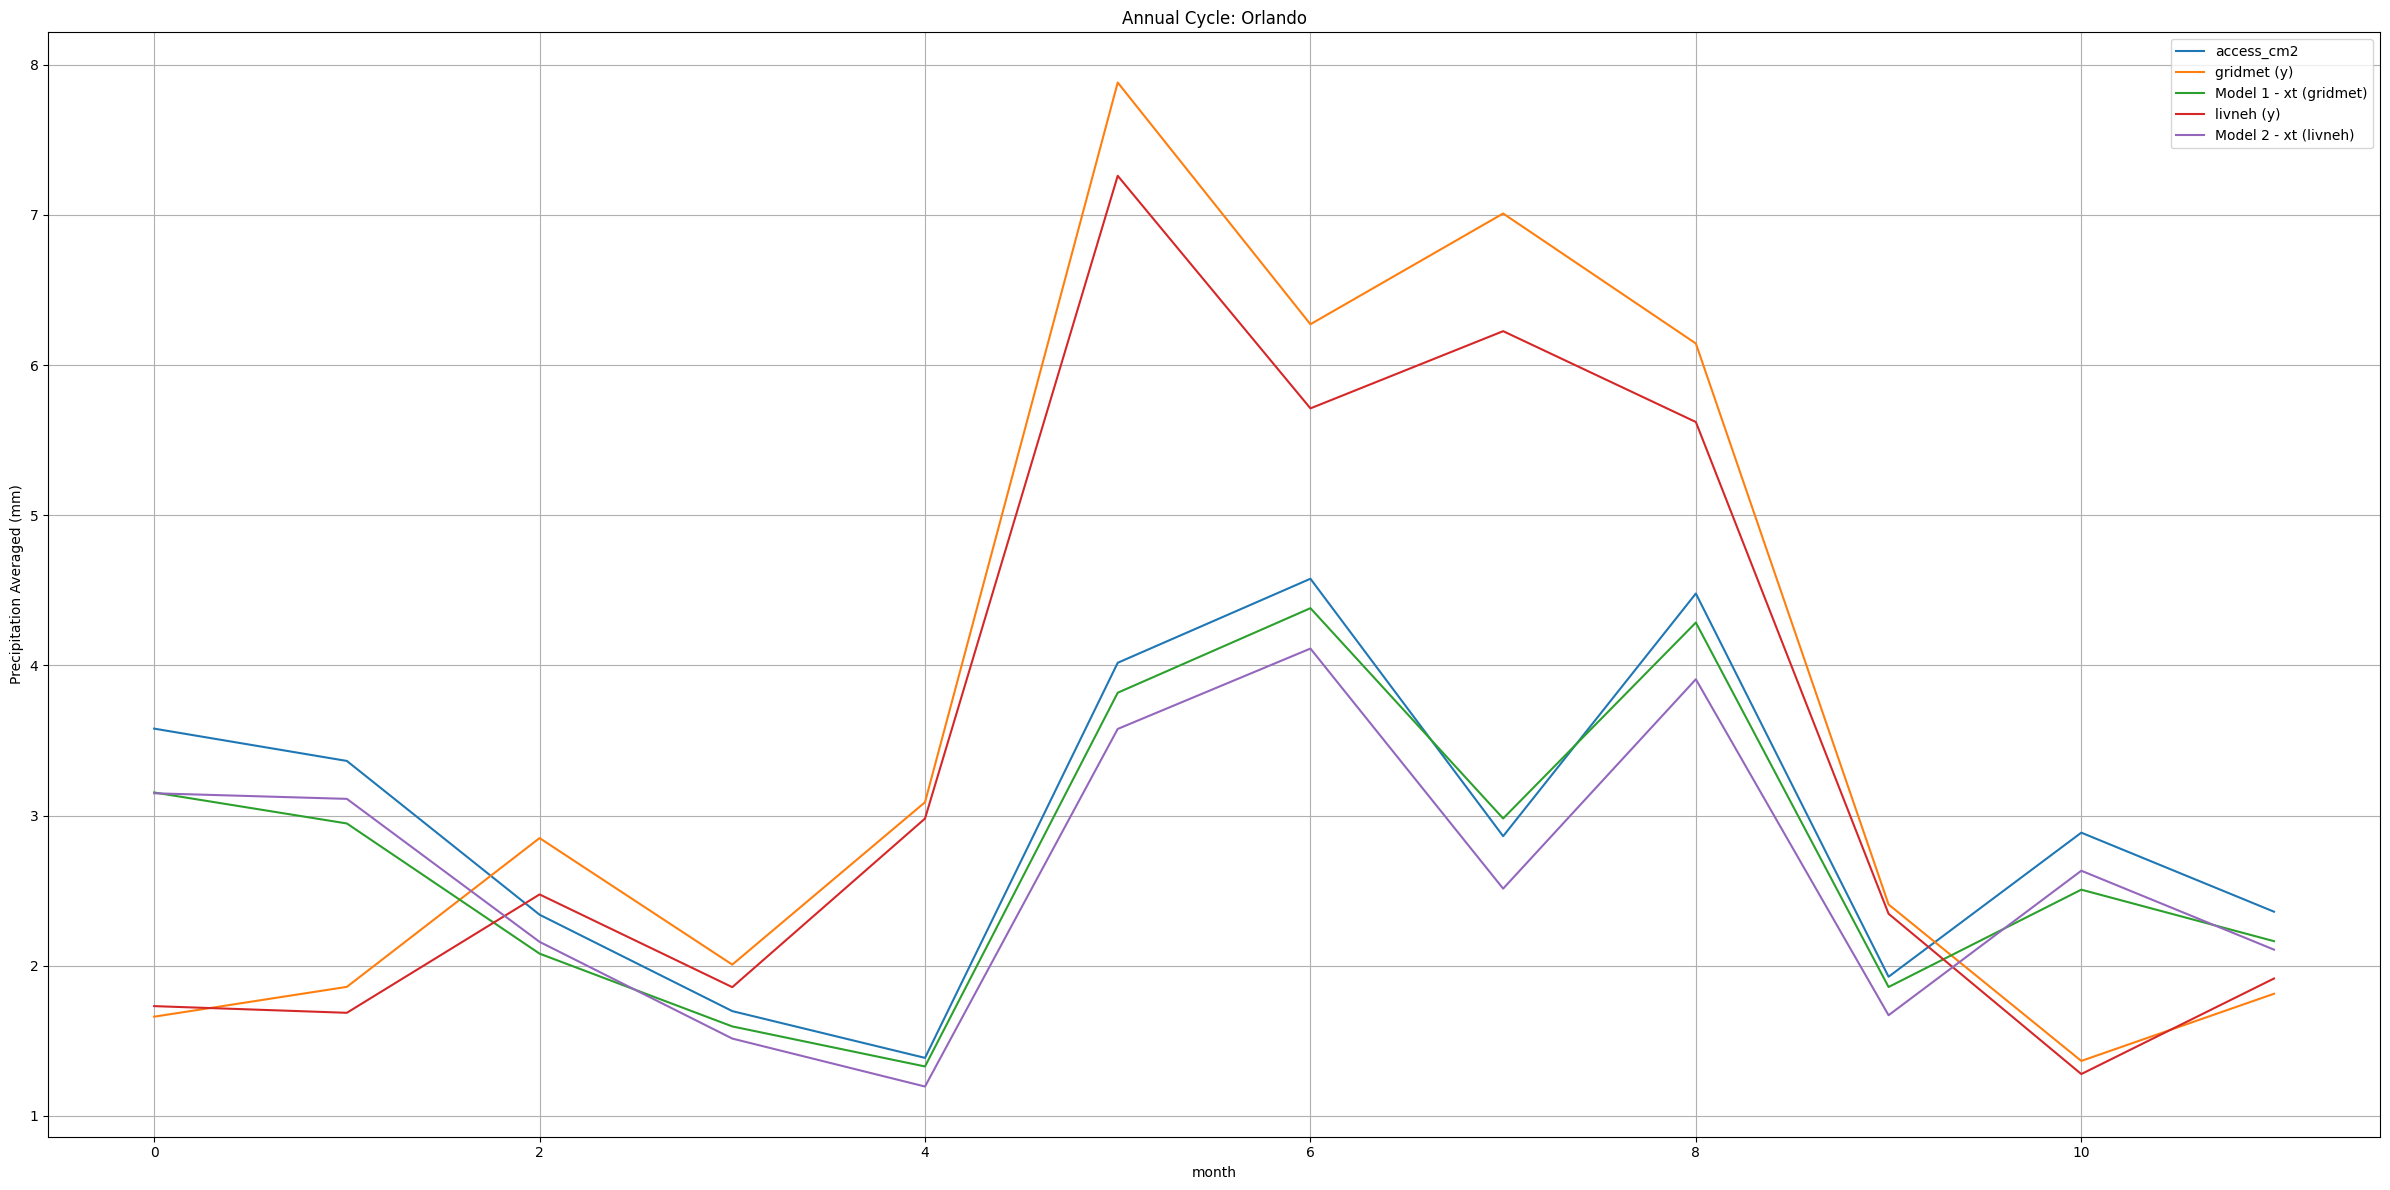

In [52]:
window_size = 1  # Adjust this as needed
scale = 'month'
for j in range(len(cities)):

    time_labels = helper.extract_time_labels(models[0]['x_time_np'], label_type=scale)

    label_dummies = pd.get_dummies(time_labels)
    weights_np = label_dummies.div(label_dummies.sum(axis=0), axis=1).values.astype(np.float32)

    loc = nearest_indices[j]

    plt.figure(figsize=(24, 12))

    scaled_x = np.einsum('ts,tm->sm', models[0]['x'] , weights_np)  # (sites, scale)
    clim_label = models[0]['config']['clim']

    smoothed_x = moving_average(scaled_x[loc], window_size)
    # mean_x = scaled_x.mean(axis=0)
    # smoothed_x = moving_average(mean_x, window_size)

    plt.plot(smoothed_x, label=f'{clim_label}')



    for i in range(len(models)):
        # weights_np.shape
        scaled_y = np.einsum('ts,tm->sm', models[i]['y'] , weights_np)  # (sites, scale)
        scaled_xt = np.einsum('ts,tm->sm', models[i]['xt'] , weights_np)  # (sites, scale)

        ref_label = models[i]['config']['ref']

        # You can average across sites to reduce to 1D curves:
        # mean_y = scaled_y.mean(axis=0)
        # mean_xt = scaled_xt.mean(axis=0)
        
        # Apply moving average to the first site's data
        smoothed_y = moving_average(scaled_y[loc], window_size)
        smoothed_xt = moving_average(scaled_xt[loc], window_size)

        # smoothed_y = moving_average(mean_y, window_size)
        # smoothed_xt = moving_average(mean_xt, window_size)

        plt.plot(smoothed_y, label=f'{ref_label} (y)')
        plt.plot(smoothed_xt, label=f'Model {i+1} - xt ({ref_label})')


    plt.xlabel(scale)
    plt.ylabel('Precipitation Averaged (mm)')
    plt.title(f'Annual Cycle: {list(cities.keys())[j]}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


(692,)